# Instacart Market Basket Analysis
- Which products will an Instacart consumer purchase again?  
- Open sourced data from kaggle competetion.
    - https://www.kaggle.com/c/instacart-market-basket-analysis

## 추가사항
1. imbalanced data가 가진 문제를 해결하기 위해서 모델의 hyper parameter에 `'is_unbalance': True` 추가
2. `learning_rate`과 `num_boost_round` 조절로 overfitting 문제 해결
3. `boosting_type`으로 dart(Dropouts meet Multiple Additive Regression Trees) 활용 방안 검토 중

## Objective
1. 오픈 소스로 공개된 Instacart e-commerce 데이터를 활용하여 **Boosting model**에 대한 공부를 하고 나아가 kaggle에 submission까지 제출해보는 것이 목적입니다.
2. Boosting 단위를 tree 기반 모델로 하여 feature importance를 계산하고, 구매에 관여하는 가장 중요한 특징이 무엇인지 알아봅니다.
3. 결제 전 마지막 단계에서 고객에게 주문 상품을 제안하는 등의 방법으로 고객의 쇼핑 경험을 보조하는 기대효과가 예상됩니다.

---

## About Instacart
> https://www.instacart.com/

- Instacart는 각종 마트 홈 딜리버리 서비스를 제공하는 식료품 구매 대행 서비스 업체입니다.
- 고객의 주문이 들어오면, Instacart의 직원이 고객 대신 마켓에서 물품들을 구매한 후 1~2시간 내로 배달하고 배달비를 받습니다.
- 예를 들어 35달러 가량을 주문하면 배송비로 4~6달러가 더해집니다. PC와 스마트폰에서 모두 주문이 가능합니다.
- 2019년 1월 기준으로 연회비 99달러의 express membership을 얻으면 35불 이상의 order는 무료로 이용가능하며 비회원은 건당 5.99달러의 추가비용이 발생합니다.
- Walmart나 e-bay같은 일반적인 유통업체와 달리 재고나 저장, 관리 등에 대한 비용이 들지 않으며, 각 지역의 슈퍼마켓들을 유기적으로 연결해 하나의 가상 상점으로 구성한다는 점이 대표적인 특징입니다.



### Partnership
![partnership](./img/local_mart.png)
>Instacart는 고객이 속한 지역의 다양한 Local market을 연결해주는 역할을 합니다.

---

## Structure of data

### Database schema
![database_schema](./img/kaggle_instacart__data_schema.png)

- 3개의 id를 중심으로 연결되어 구성되어 있는 형태입니다.
    - `user_id`
    - `order_id`
    - `product_id`
- order_products__prior과 order_products__train의 차이
    - orders의 feature 중 `eval_set`에서 모든 order들을 3개의 카테고리로 나누고 있습니다.
    - 모든 user들의 마지막 order을 제외한 order가 `prior`입니다.
    - 마지막 order들 중 재구매 여부가 공개된 order가 `train`, 그렇지 않은 order가 `test`입니다.
    - order_products__prior과 order_products__train는 각각 `prior`, `train`에 해당하는 order로 묶여있는 dataframe입니다.

## Description
- https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

>우리에게 주어진 문제는 user의 가장 최근에 발생한 주문의 상품 리스트에서 재구매된 상품이 무엇인지를 예측하는 문제입니다. `train`으로 분류된 order는 주문된 상품의 리스트와 re-order 라벨링이 되어있고, `test`로 분류된 것들은 답이 없습니다. 그리고 kaggle competetion에서 요구하는 답은 `test` 주문들에서 재주문된 상품들을 예측한 리스트입니다.  

---

# Import

In [1]:
import seaborn as sns
import lightgbm as lgb
import operator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from copy import deepcopy

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%matplotlib inline

In [3]:
IDIR = './data/'
order_products_train_df = pd.read_csv(IDIR + "order_products__train.csv", dtype={
            'order_id': np.int64,
            'product_id': np.int64,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

order_products_prior_df = pd.read_csv(IDIR + "order_products__prior.csv", dtype={
            'order_id': np.int64,
            'product_id': np.int64,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

orders_df = pd.read_csv(IDIR + "orders.csv", dtype={
        'order_id': np.int64,
        'user_id': np.int64,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

products_df = pd.read_csv(IDIR + "products.csv", dtype={
        'product_id': np.int64,
        'order_id': np.int64,
        'aisle_id': np.uint8,
        'department_id': np.uint8})

aisles_df = pd.read_csv(IDIR + "aisles.csv", dtype={
        'aisle_id': np.uint8})

departments_df = pd.read_csv(IDIR + "departments.csv", dtype={
        'department_id': np.uint8})

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [7]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
products_df.shape

(49688, 4)

In [10]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


---

# EDA

### Maximum of `Order_number`

고객들이 instacart에서 주문한 횟수의 분포를 보겠습니다.

In [12]:
order_count_per_user = orders_df.groupby(by='user_id')['order_number'].aggregate('max').reset_index()
order_count_per_user.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


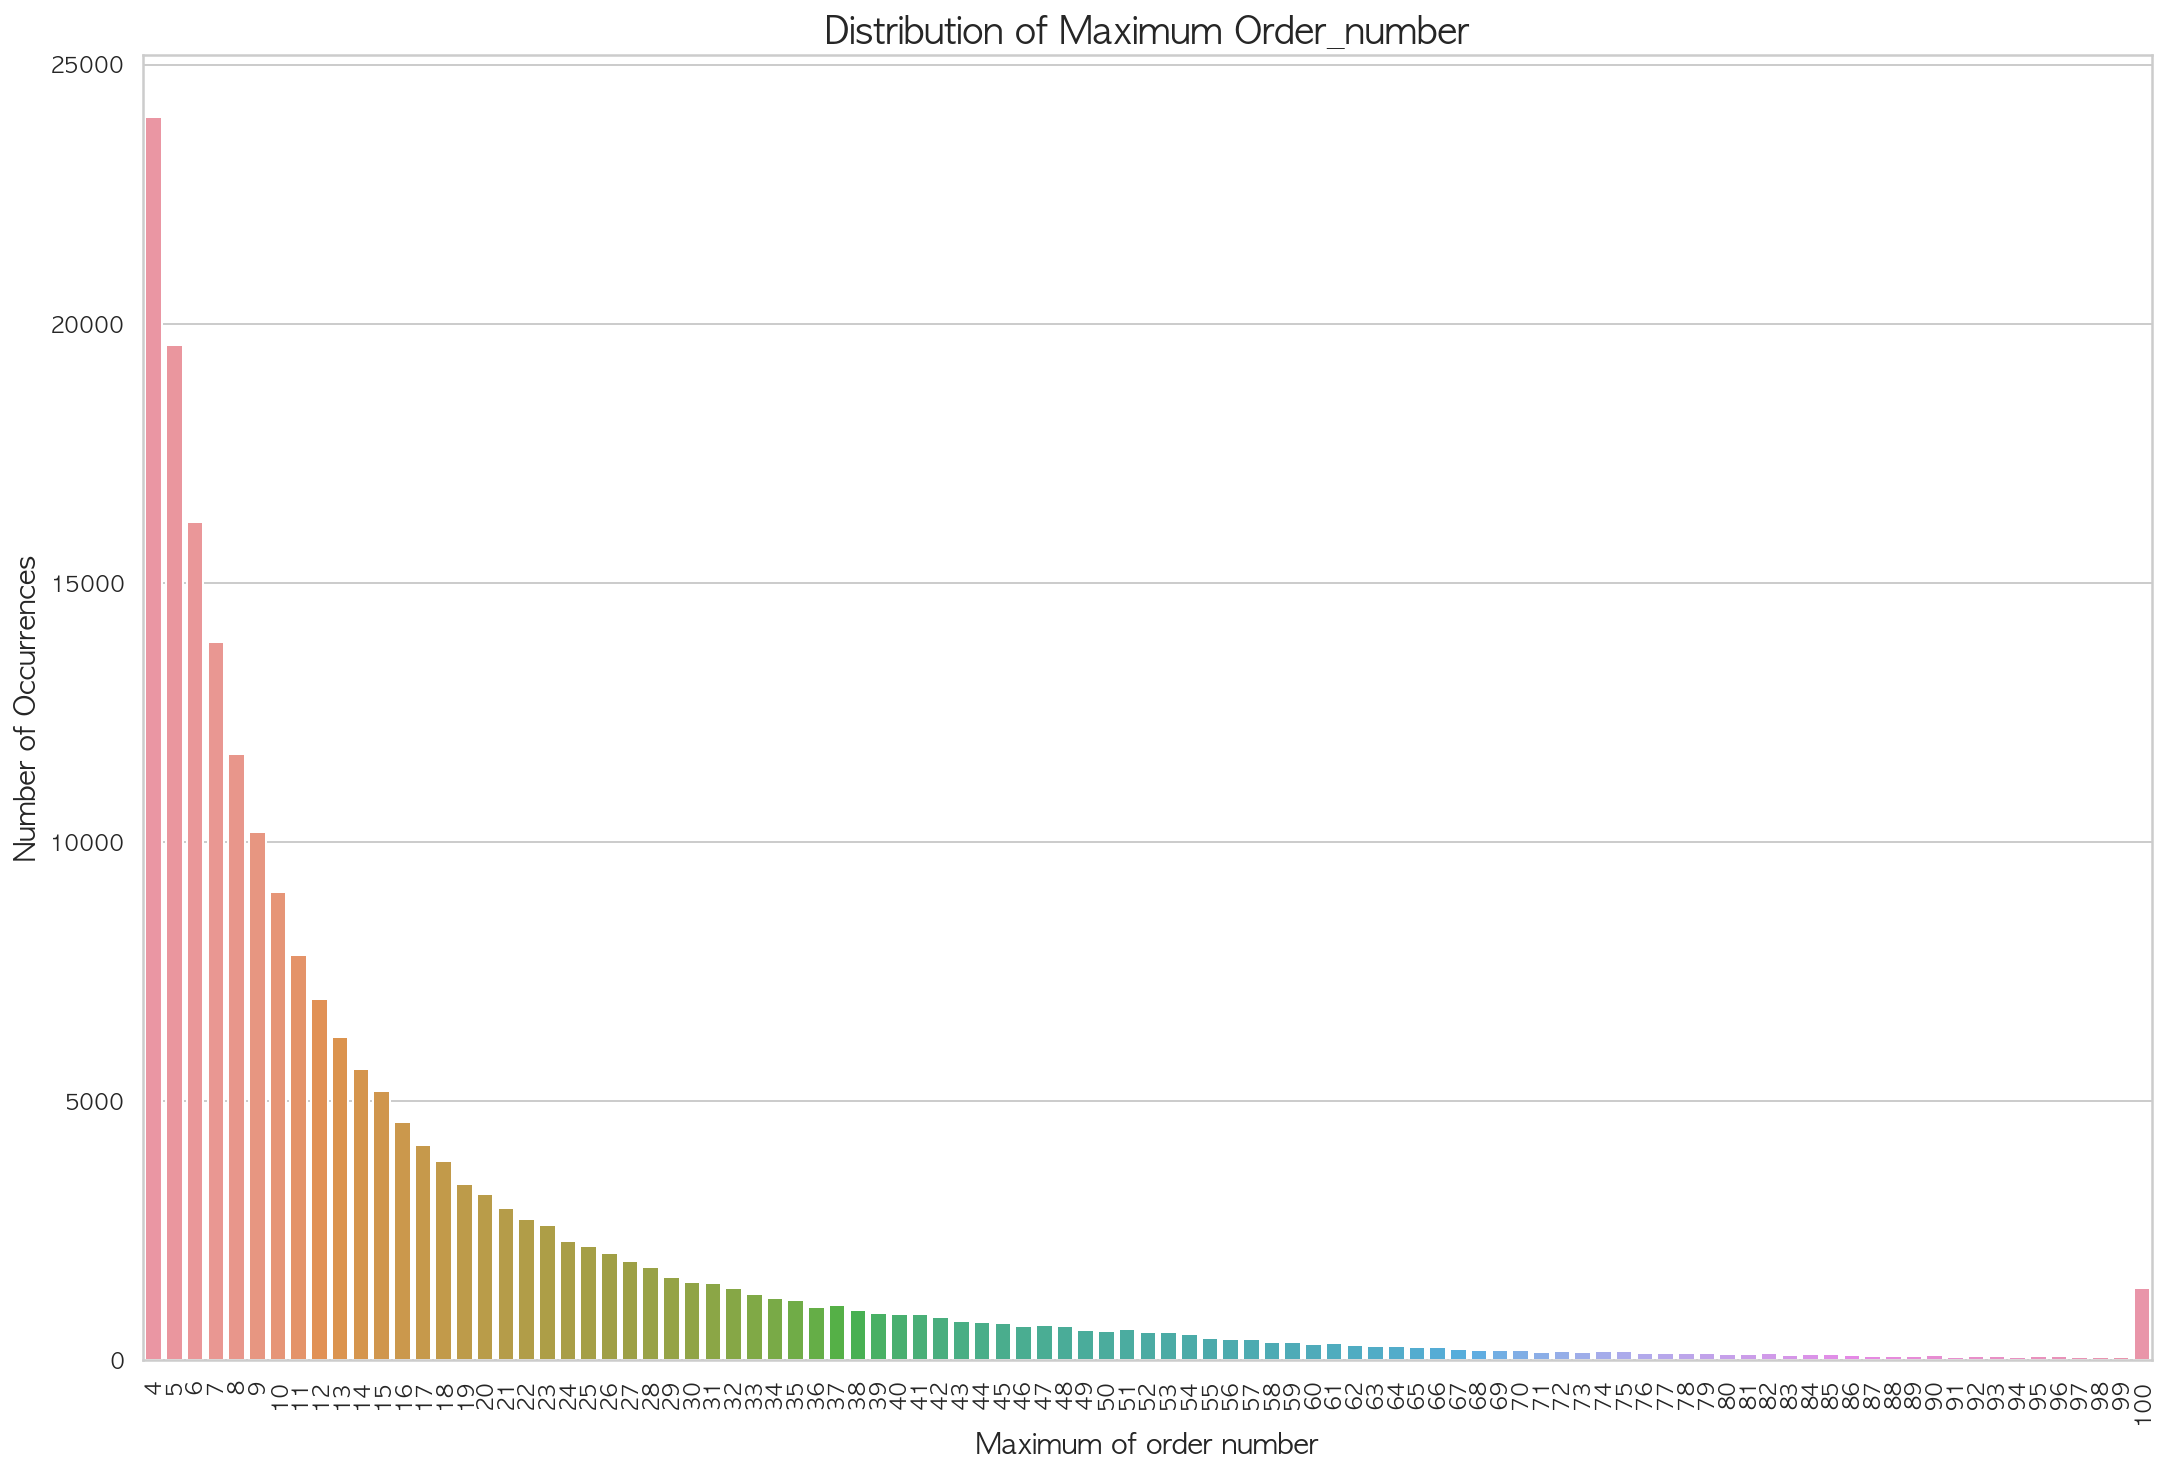

In [13]:
max_order_number = order_count_per_user['order_number'].value_counts()

plt.figure(figsize=(18, 12))
sns.barplot(x=max_order_number.index, y=max_order_number.values)
plt.title('Distribution of Maximum Order_number', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Maximum of order number', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

>각 고객들은 최소 4번, 최대 100번의 주문을 했습니다(100번 이상은 100으로 truncate된 듯 합니다).

### 주문의 시간적 분포

`orders.csv`에서 `order_dow`와 `order_hour_of_day`은 각각 주문이 시행된 요일과 그 날의 시간대를 의미합니다. 이를 통해서 시행된 주문들의 시간적 분포를 확인해보겠습니다.

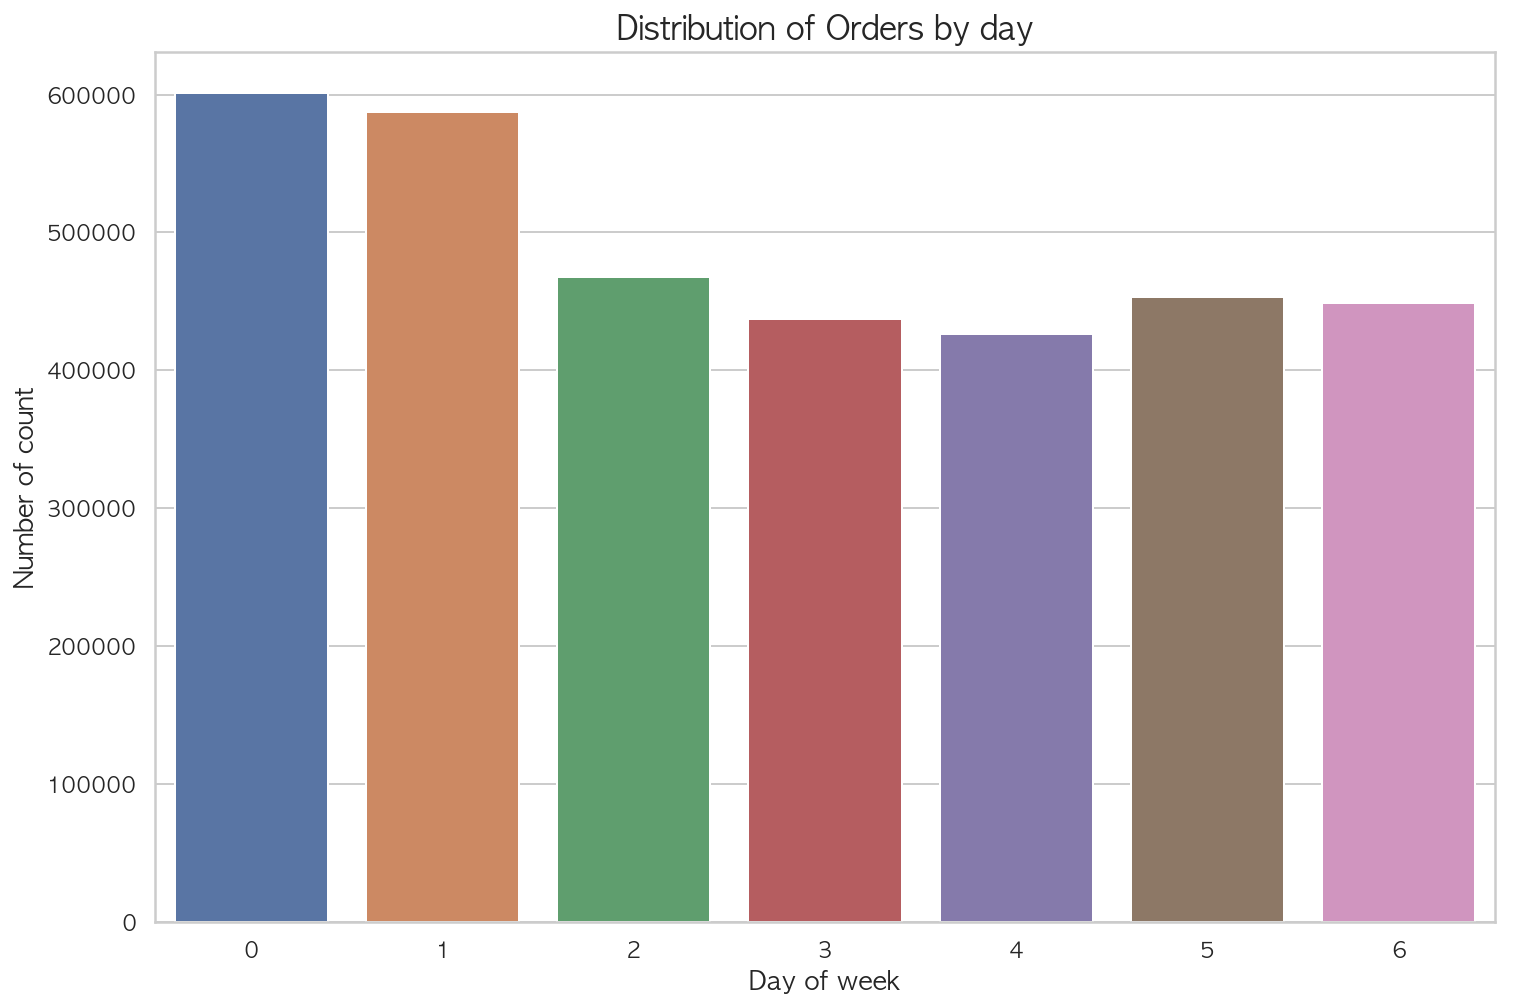

In [14]:
week_cnt = orders_df['order_dow'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(week_cnt.index, week_cnt.values)
plt.title('Distribution of Orders by day', fontsize=16)
plt.xlabel('Day of week', fontsize=13)
plt.ylabel('Number of count', fontsize=13)
plt.show()

일요일과 월요일이 다른 요일보다 약 15~18% 정도 주문량이 더 많은 것을 확인할 수 있습니다.

>Description에 정확히 서술되지는 않았지만, 보통 1주일의 시작을 일요일로 잡는 경우가 보편적이므로 요일의 시작(0)을 토요일, 끝(6)을 금요일로 가정하면 될 것 같습니다.

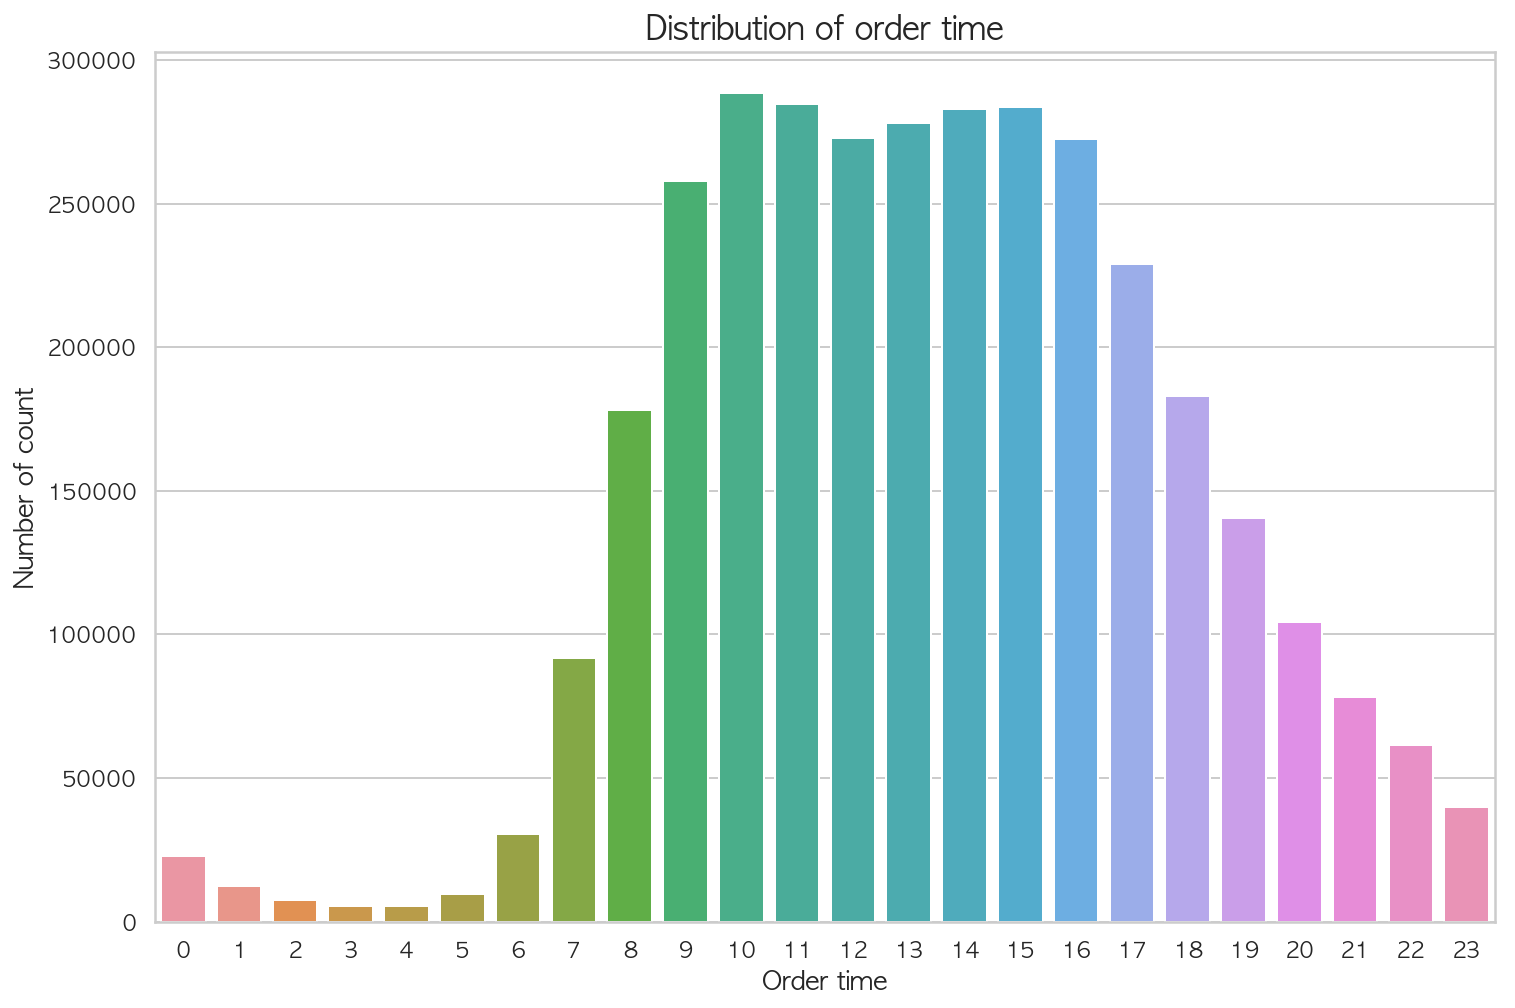

In [15]:
time_cnt = orders_df['order_hour_of_day'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(time_cnt.index, time_cnt.values)
plt.title('Distribution of order time', fontsize=16)
plt.xlabel('Order time', fontsize=13)
plt.ylabel('Number of count', fontsize=13)
plt.show()

>주문이 가장 많이 이루어지는 시간대는 오전 10시 ~ 오후 3시 입니다.

위의 두 가지 속성을 조합하여 2차원 플롯으로 시각화하여 한번에 표현해 보겠습니다.

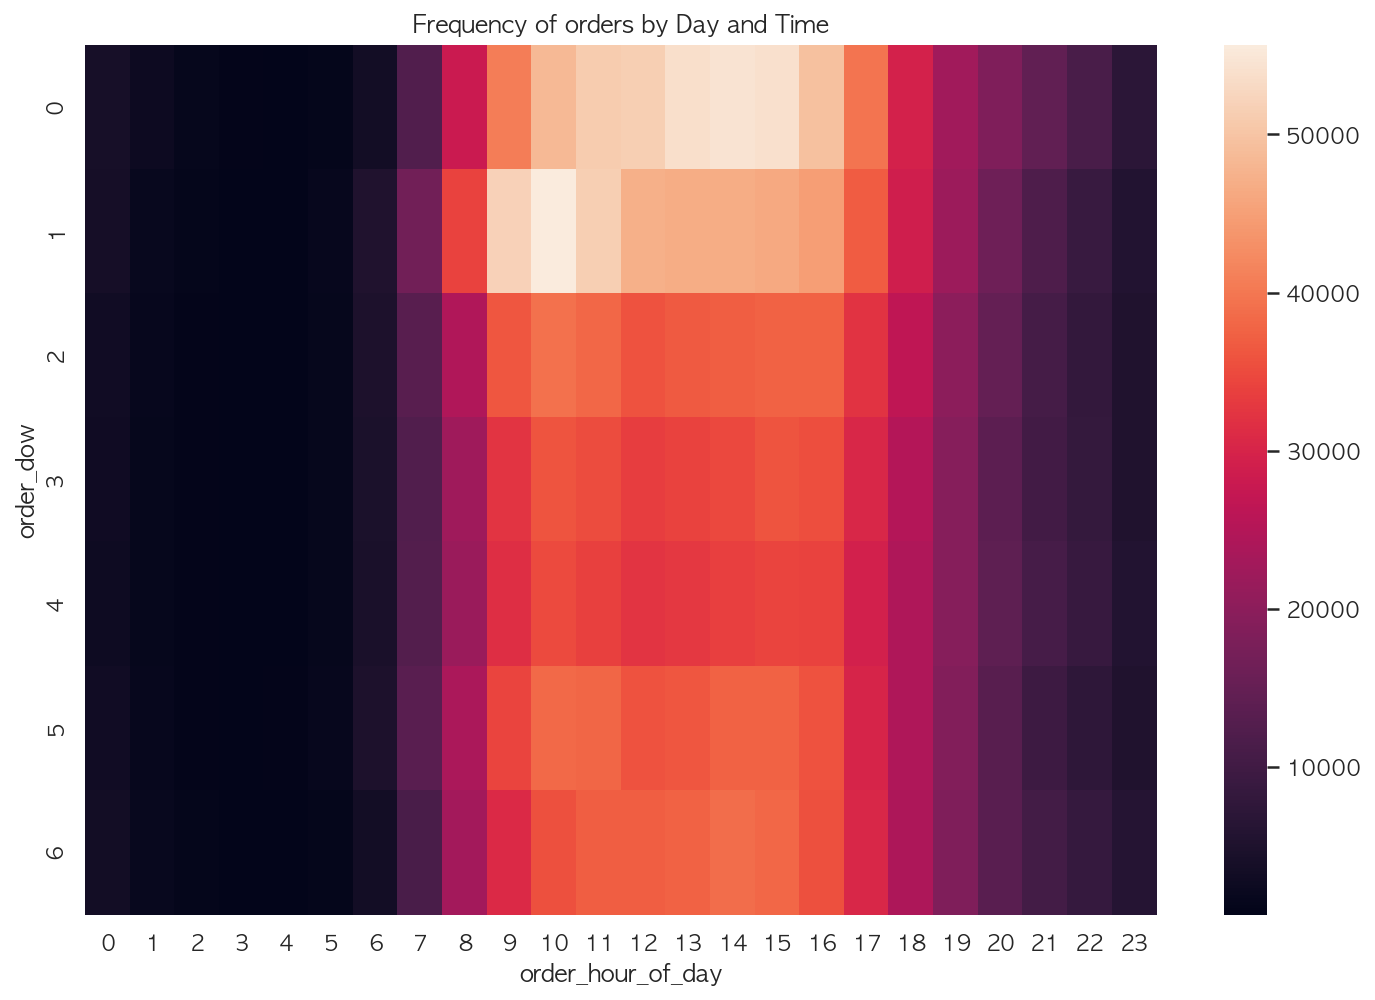

In [16]:
time_table = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
time_table = time_table.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12, 8))
plt.title("Frequency of orders by Day and Time")
sns.heatmap(time_table)
plt.show()

>토요일 오후, 일요일 오전에 주문이 가장 많이 이루어지는 것을 확인할 수 있습니다.

그 전 주문으로부터 몇 일 후에 다시 주문이 이루어져있는지를 나타내는 `days_since_prior_order`의 분포를 확인해보겠습니다.

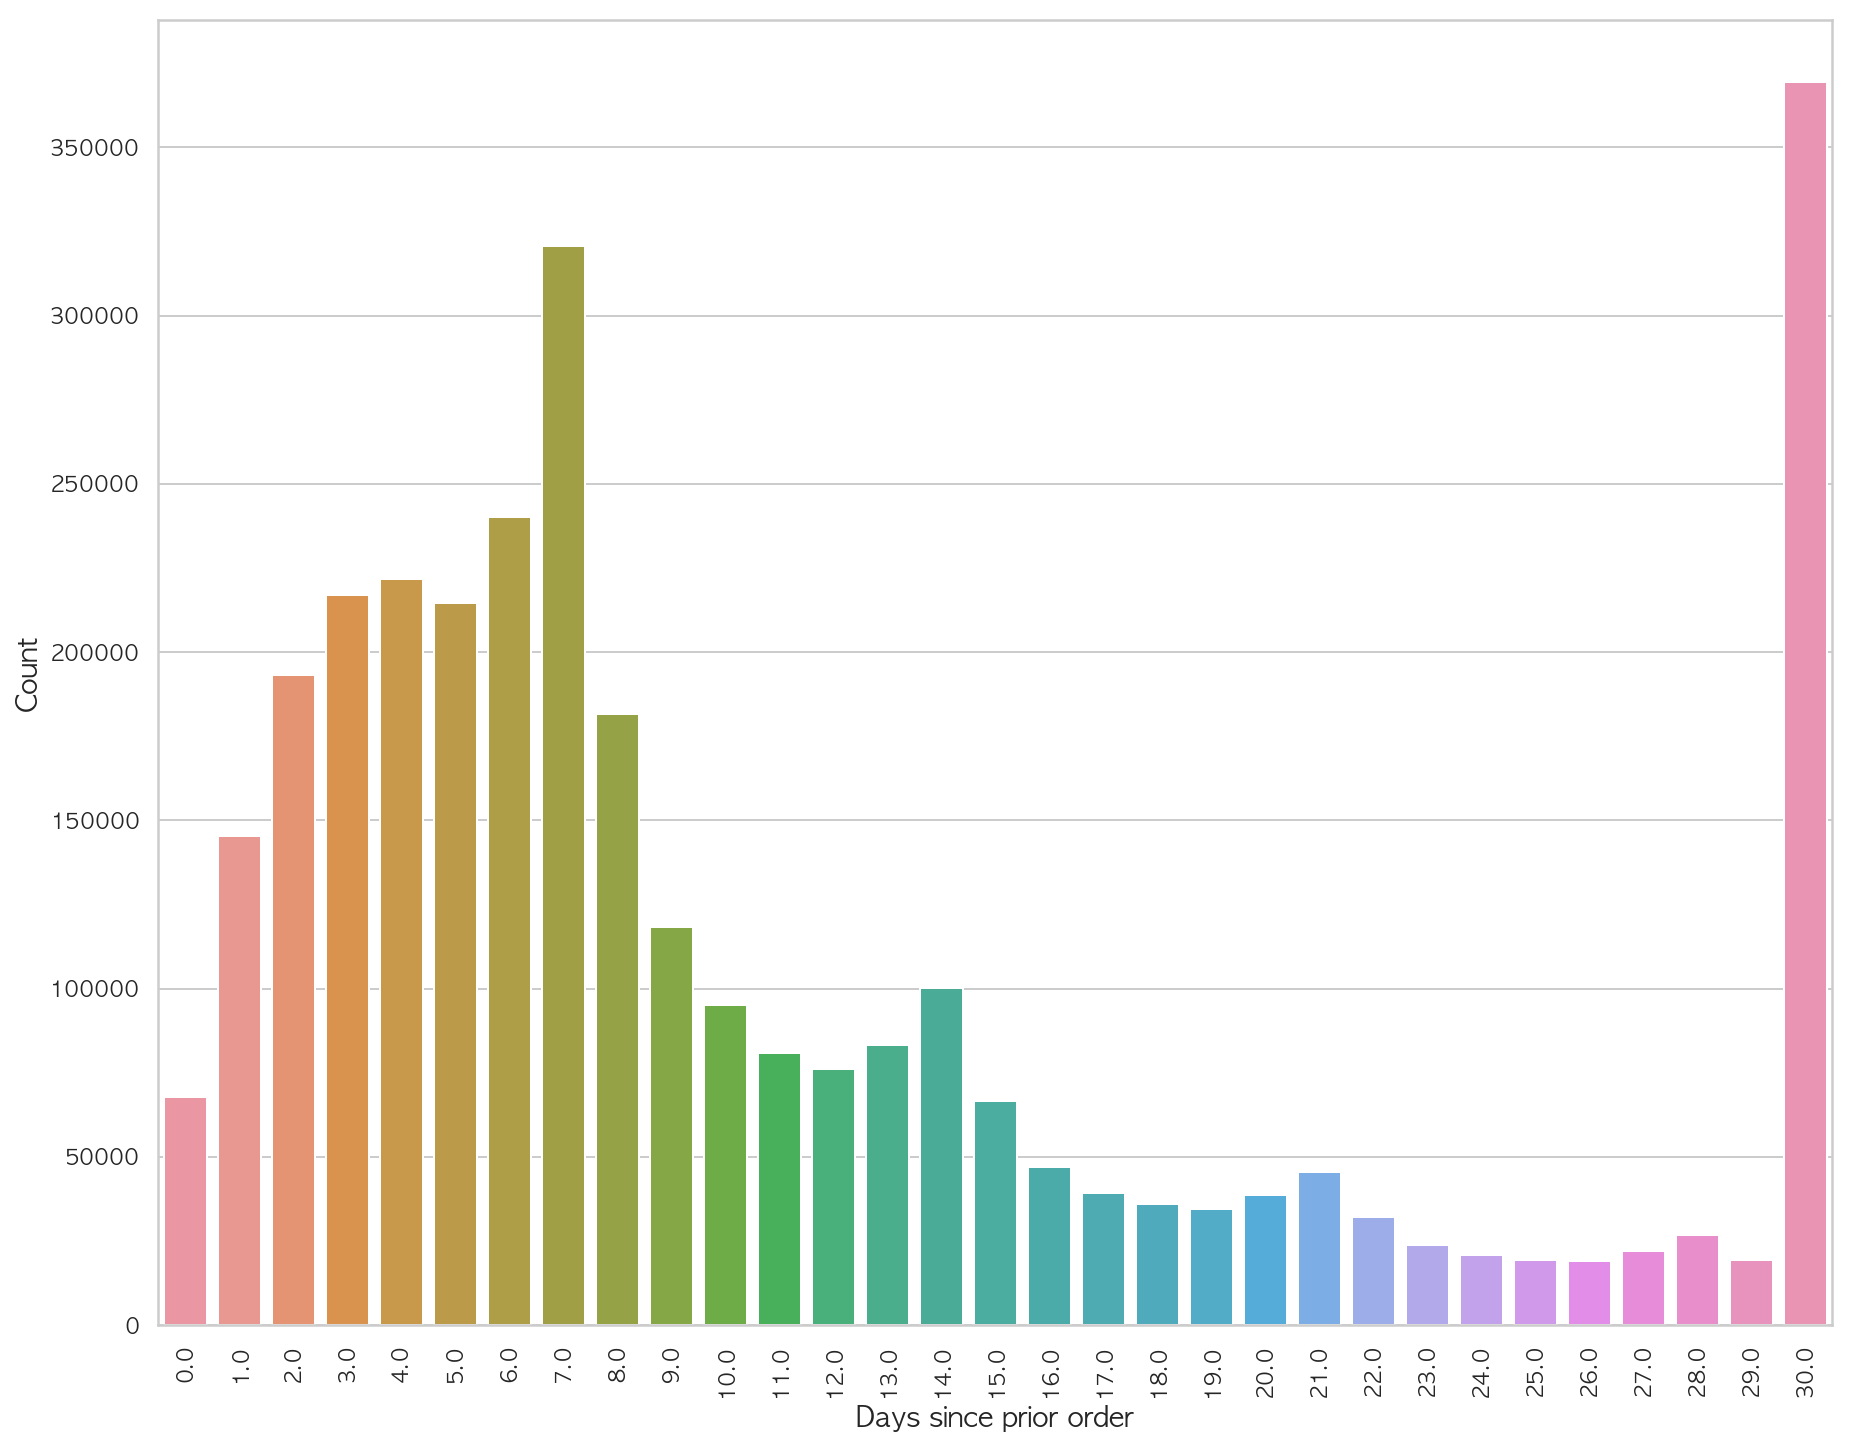

In [17]:
plt.figure(figsize=(15, 12))
sns.countplot(x="days_since_prior_order", data=orders_df)
plt.xlabel('Days since prior order', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

>방금 전 Maximum order number과 마찬가지로 30일 이상의 경우는 30일로 truncate된 것으로 보입니다. 이 경우를 제외하면 7일을 주기로 재주문이 이루어지는 경우가 가장 많습니다.

### `prior`, `train`, `test`의 비율

In [18]:
eval_set_cnt = orders_df['eval_set'].value_counts()
eval_set_cnt

prior    3214874
train    131209 
test     75000  
Name: eval_set, dtype: int64

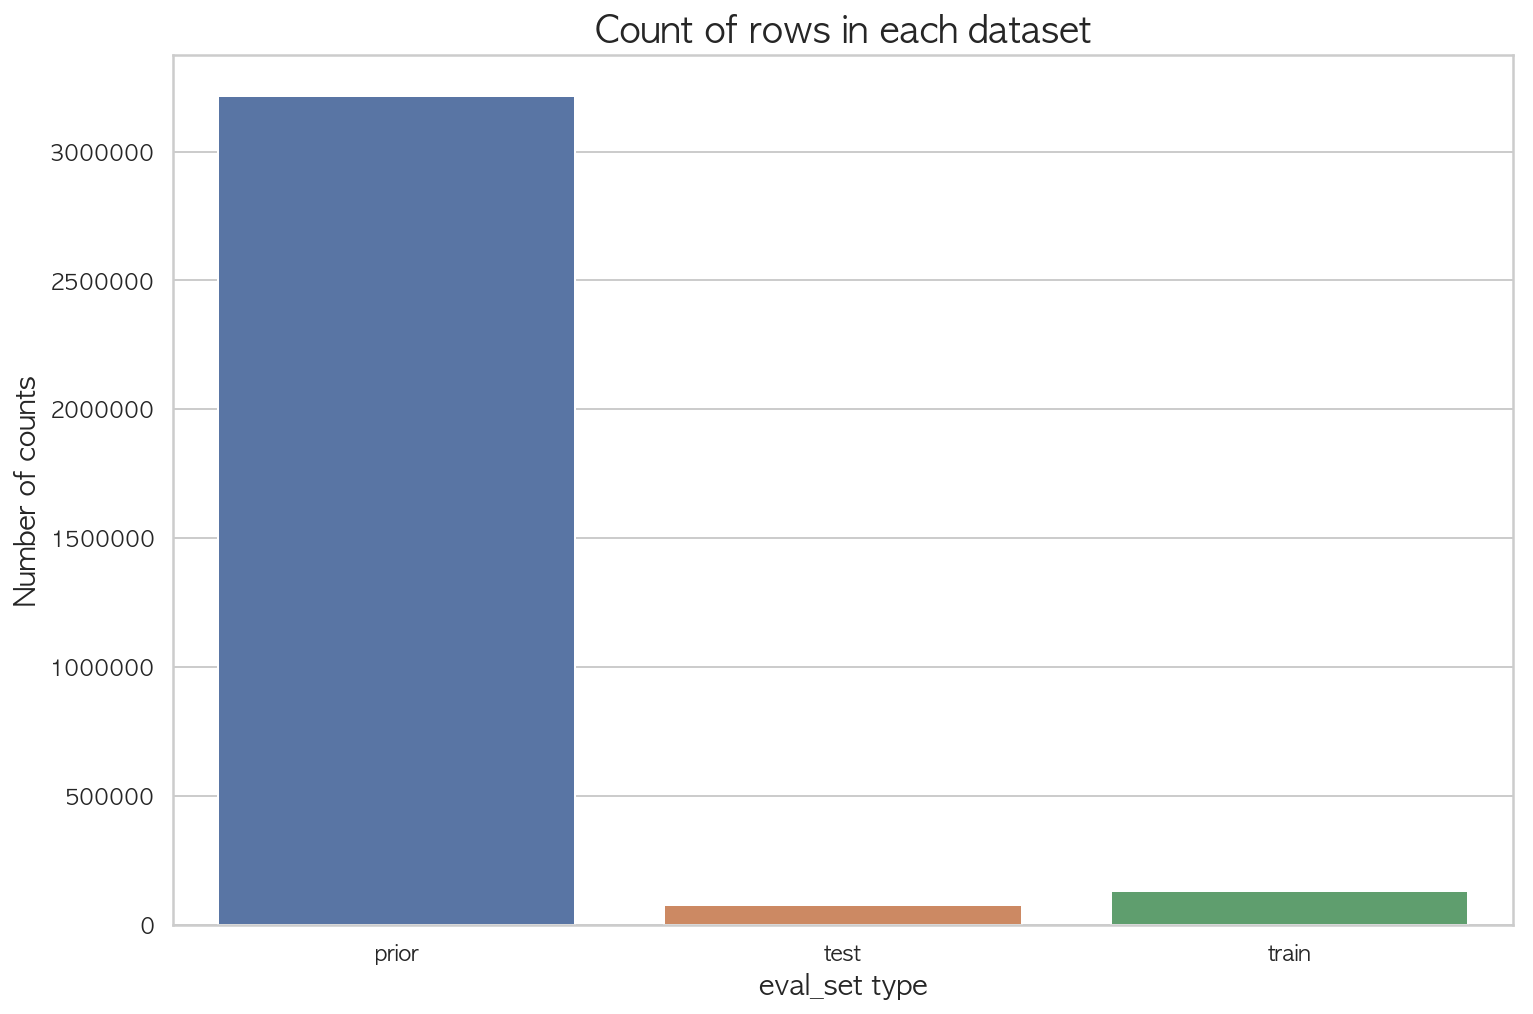

In [19]:
plt.figure(figsize=(12, 8))
sns.barplot(eval_set_cnt.index, eval_set_cnt.values)
plt.ylabel('Number of counts', fontsize=14)
plt.xlabel('eval_set type', fontsize=14)
plt.title('Count of rows in each dataset', fontsize=18)
plt.show()

`prior`은 마지막을 제외한 order들이므로 user_id를 기준으로 unique하게 만들어 user가 총 몇 명인지 알아보겠습니다.

In [20]:
def unique_count(x):
    return len(np.unique(x))

eval_set_cnt = orders_df.groupby(by='eval_set').agg(unique_count)['user_id']
eval_set_cnt

eval_set
prior    206209
test     75000 
train    131209
Name: user_id, dtype: int64

총 206,209명의 order 데이터로 만들어진 데이터입니다. 최종적으로 우리는 206,209명의 고객 중 75,000명의 주문 상품을 예측해야 합니다.

### 가장 많이 재주문된 상품들

우선 분석을 위해서 merge 작업을 합니다.

In [23]:
df = pd.merge(order_products_prior_df, orders_df, how='left', on='order_id')
df = pd.merge(df, products_df, how='left', on='product_id')
df = pd.merge(df, aisles_df, how='left', on='aisle_id')
df = pd.merge(df, departments_df, how='left', on='department_id')
df.tail()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0,Banana,24,4,fresh fruits,produce
32434488,3421083,5020,10,1,25247,prior,24,2,6,21.0,Organic Sweet & Salty Peanut Pretzel Granola Bars,3,19,energy granola bars,snacks


In [24]:
len(df['product_name'].unique())

49677

대략 5만개 정도의 상품이 존재합니다.

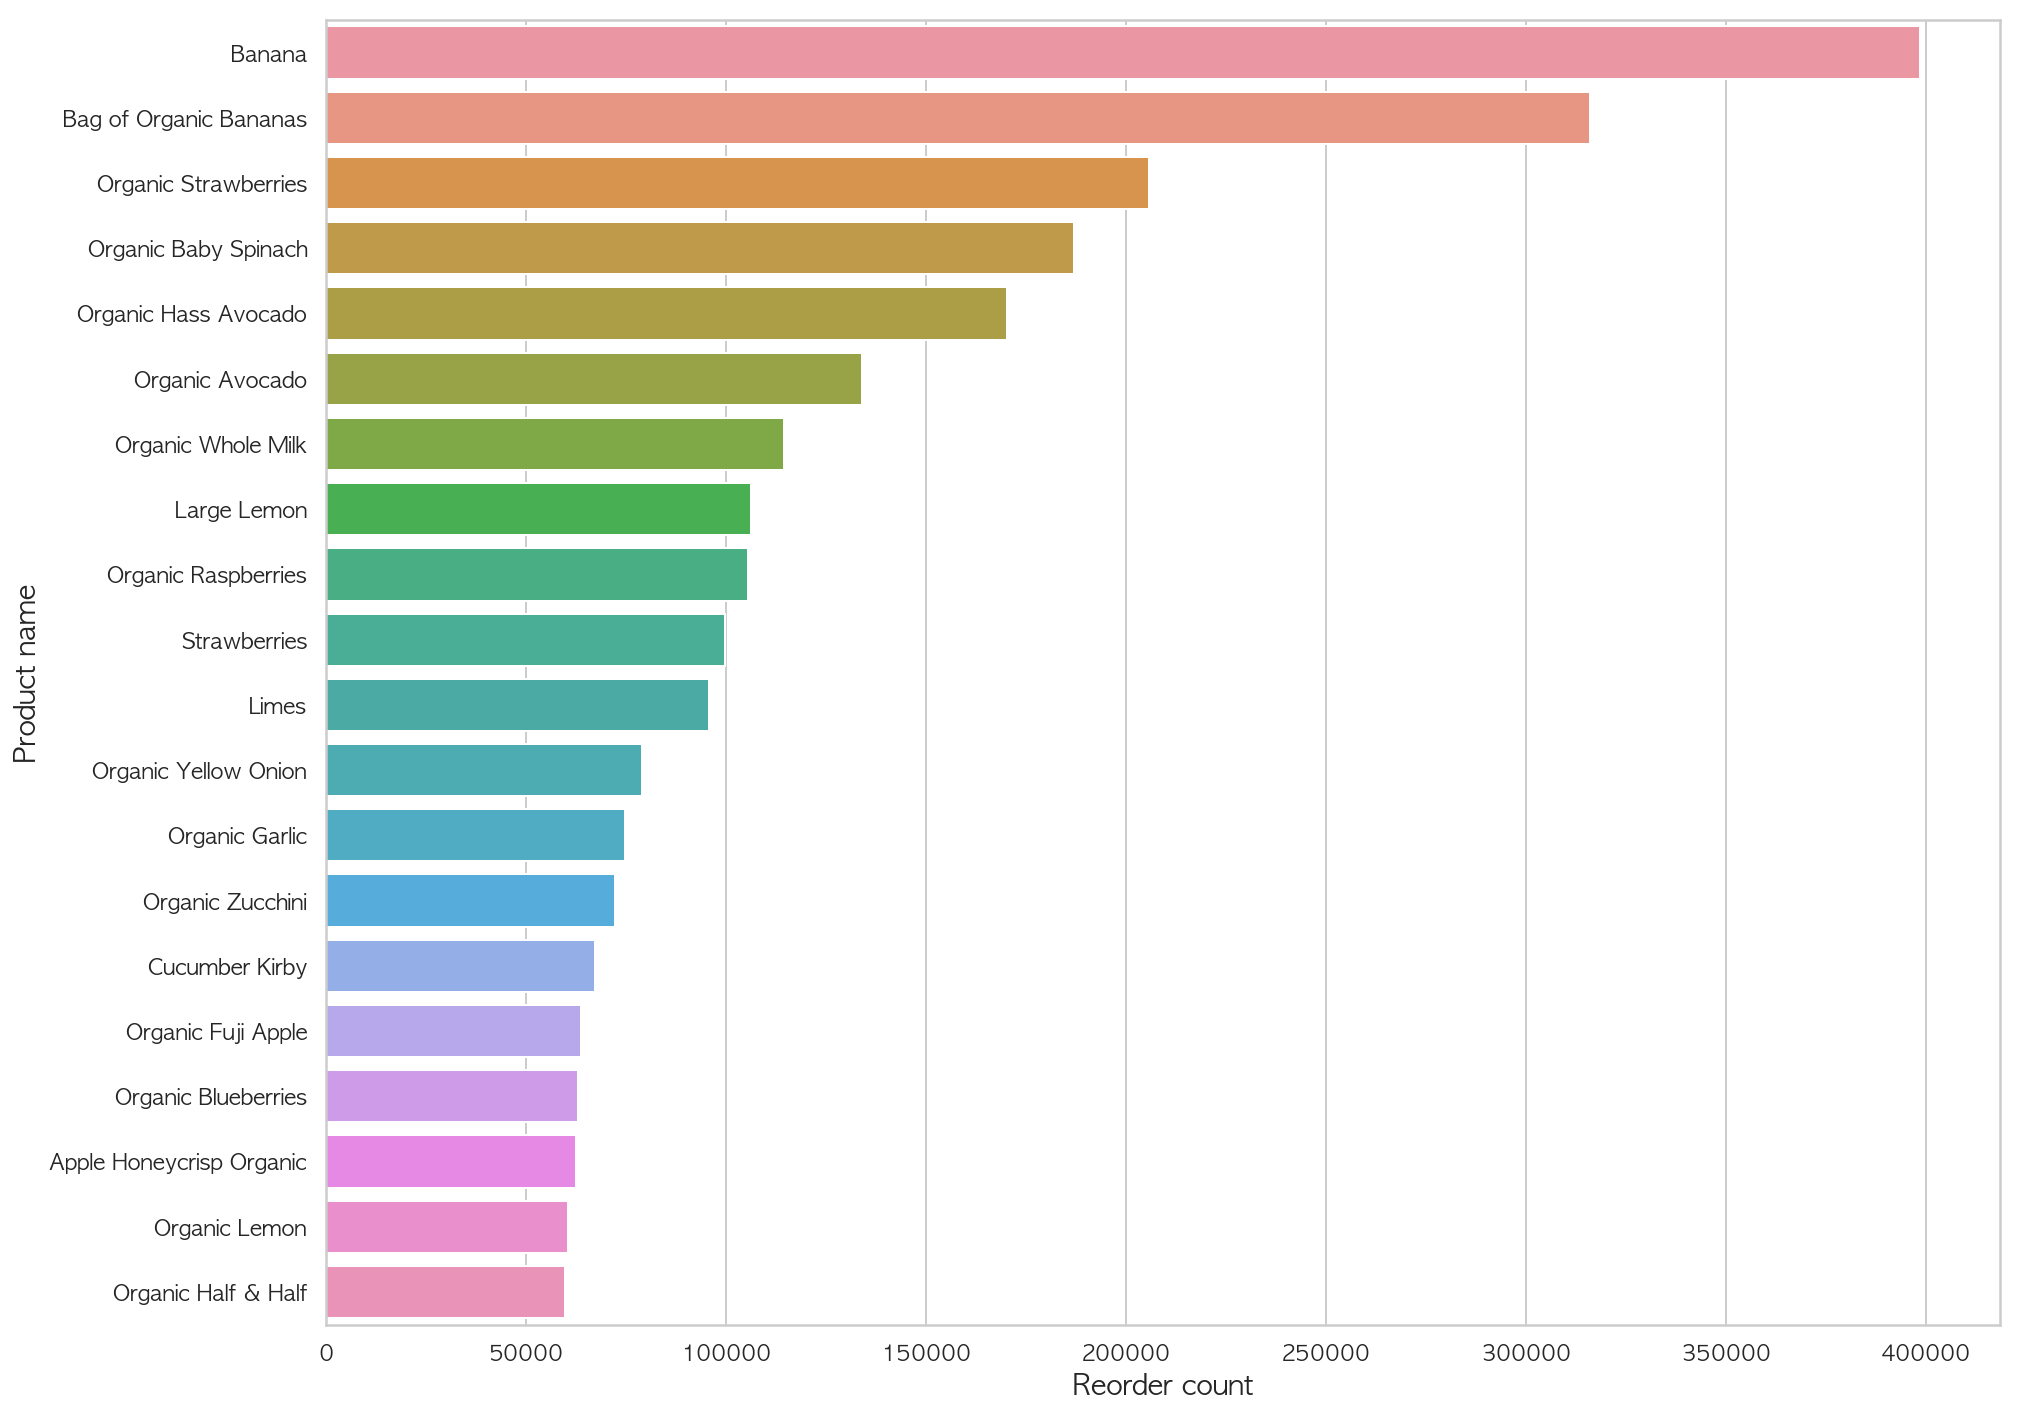

In [25]:
product_rank = df[['reordered', 'product_name']].groupby(by='product_name').sum().astype(np.int32)\
.sort_values(by=['reordered'], ascending=False).head(20).reset_index()
plt.figure(figsize=(15, 12))
sns.barplot(x="reordered", y='product_name', data=product_rank)
plt.xlabel('Reorder count', fontsize=14)
plt.ylabel('Product name', fontsize=14)
plt.show()

>대부분 신선도가 중요한 과일 & 채소군이며 top20 중 14개가 유기농(Organic) 제품인 것을 확인할 수 있습니다.

### Organic products

In [26]:
products_df['is_organic'] = products_df['product_name'].apply(lambda x: 1 if 'Organic' in x else 0)

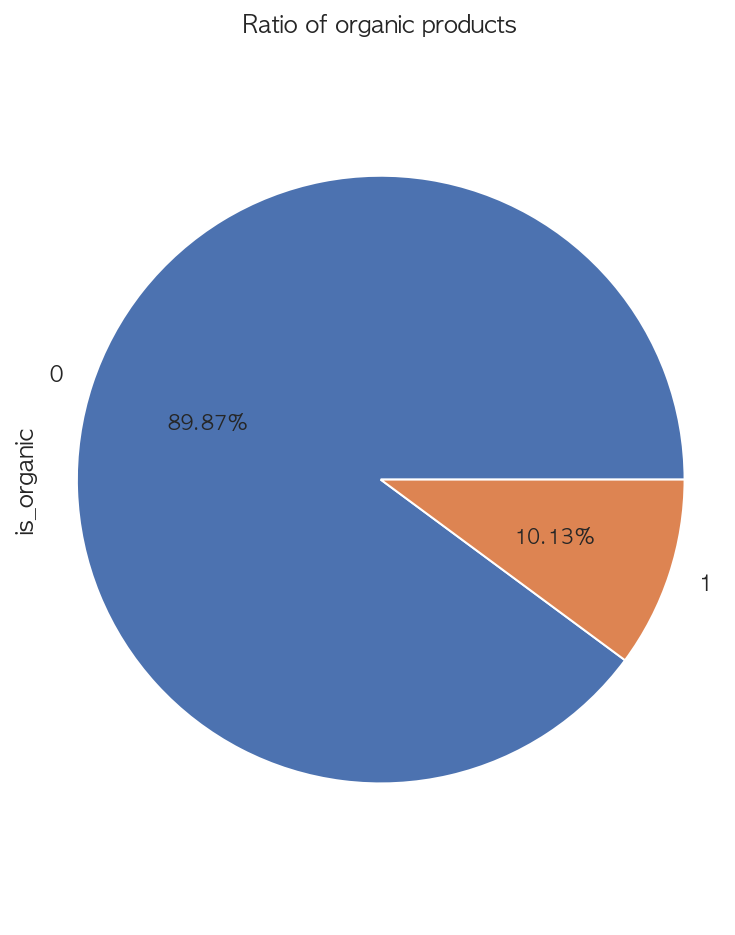

In [27]:
organic_ratio = products_df.is_organic.value_counts()
plt.figure(figsize=(6, 8))
organic_ratio.plot.pie(autopct='%.2f%%')
plt.title("Ratio of organic products")
plt.axis('equal')
plt.show()

>유기농 상품은 전체 상품에서 약 10% 정도를 차지하고 있습니다.

### 상품군 분석

#### aisle
마켓에서 복도 단위로 나누어져 있는 상품 코너를 의미합니다.

![aisle](./img/aisle.jpg)
##### source by https://www.tripadvisor.com/LocationPhotoDirectLink-g147366-d4274858-i199064904-Kirk_Market-George_Town_Grand_Cayman_Cayman_Islands.html

In [28]:
len(df['aisle'].unique())

134

In [29]:
aisle_rank = df[['reordered', 'aisle']].groupby(by='aisle').sum().astype(np.int32)\
.sort_values(by=['reordered'], ascending=False).reset_index()

In [30]:
aisle_rank[:10]

,aisle,reordered
0,fresh fruits,2615469
1,fresh vegetables,2032172
2,packaged vegetables fruits,1127177
3,yogurt,997018
4,milk,696264
5,water seltzer sparkling water,613977
6,packaged cheese,573383
7,soy lactosefree,442023
8,chips pretzels,425387
9,bread,391937


In [31]:
aisle_rank[-10:]

,aisle,reordered
124,deodorants,3509
125,ice cream toppings,2990
126,shave needs,2712
127,baby bath body care,2538
128,skin care,2460
129,frozen juice,2188
130,first aid,2118
131,eye ear care,1950
132,kitchen supplies,1792
133,beauty,1308


#### department
Instacart에서 분류하고 있는 상품군입니다.


![department](./img/department.png)

In [32]:
len(df['department'].unique())

21

In [33]:
department_rank = df[['reordered', 'department']].groupby(by='department').sum().astype(np.int32)\
.sort_values(by=['reordered'], ascending=False).reset_index()

In [34]:
department_rank[:5]

,department,reordered
0,produce,6160710
1,dairy eggs,3627221
2,beverages,1757892
3,snacks,1657973
4,frozen,1211890


In [35]:
department_rank[-5:]

,department,reordered
16,alcohol,87595
17,pets,58760
18,missing,27371
19,bulk,19950
20,other,14806


>마찬가지로 aisle과 department에서도 식품군, 특히 신선도가 중요시되는 과일, 채소, 달걀, 우유 등이 높은 재주문 수치를 보였습니다.

---

# Feature engineering

## Final features
### 1. user
- 각 order 사이 간격의 평균
- 총 order의 횟수
- 주문한 총 product의 갯수
- 장바구니의 평균 사이즈(장바구니에 담은 product 갯수의 평균)
- 주문한 총 product에서 distinct한 product의 갯수
- 주문 상품의 다양성: unique한 aisle, department의 합

### 2. order
- 주문 요일(sun, mon, tue, wed, thr, fri, sat)
- 주문 시간 카테고리(morning, day, evening, night)
- 전 주문과의 간격(day)
- 전 주문과의 간격(day) / order의 간격의 평균

### 3. product
- aisle_id
- department_id
- product가 order된 총 횟수
- product가 re-order된 총 횟수
- 재주문 비율: product가 re-order된 총 횟수 / product가 order된 총 횟수
- 유기농(organic) 상품인지 여부

### 4. userXproduct
- 유저가 특정 제품을 주문한 횟수
- 특정 제품을 주문한 횟수 / 총 주문 횟수 
- 장바구니에 상품을 담은 순번 / 제품 주문 횟수
- 총 주문 횟수 - 상품이 포함된 주문의 순번
- 해당 주문이 이루어진 시간 - 가장 최근에 특정 주품을 주문한 시간

>총 21개의 feature


---

## Merge
- feature engineering을 위한 사전 작업을 합니다.

In [36]:
df = pd.merge(order_products_prior_df, orders_df, how='left', on='order_id')
df = pd.merge(df, products_df, how='left', on='product_id')
df = pd.merge(df, aisles_df, how='left', on='aisle_id')
df = pd.merge(df, departments_df, how='left', on='department_id')
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,is_organic,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,1,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,1,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,0,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,0,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,0,baking ingredients,pantry


---

## User features
- 각 order 사이 간격의 평균
- 총 order의 횟수
- 주문한 총 product의 갯수
- 장바구니의 평균 사이즈(장바구니에 담은 product 갯수의 평균)
- 주문한 총 product에서 distinct한 product의 갯수
- 주문 상품의 다양성: unique한 aisle, department의 합

In [37]:
users = pd.DataFrame()
users['avg_days_since_prior_order'] = df.groupby(by='user_id')['days_since_prior_order'].mean().astype(np.float16)
users['total_orders'] = df.groupby(by='user_id')['order_number'].max().astype(np.int16)
users['total_products'] = df.groupby(by='user_id')['product_id'].size().astype(np.int16)
users['avg_basket'] = (users['total_products'] / users['total_orders']).astype(np.float16)
users['products_id_list'] = df.groupby(by='user_id')['product_id'].agg(set)
users['total_distinct_products'] = users['products_id_list'].map(len).astype(np.int16)
users['aisle_id_list'] = df.groupby(by='user_id')['aisle_id'].agg(set)
users['department_id_list'] = df.groupby(by='user_id')['department_id'].agg(set)
users['taste_variance'] = (users['aisle_id_list'].map(len) + users['department_id_list'].map(len)).astype(np.int16)
users.drop(columns=['aisle_id_list', 'department_id_list'], inplace=True)
users

,avg_days_since_prior_order,total_orders,total_products,avg_basket,products_id_list,total_distinct_products,taste_variance
user_id,,,,,,,
1,20.265625,10,59,5.898438,"{17122, 196, 26405, 46149, 14084, 13032, 26088, 39657, 12427, 25133, 35951, 38928, 10258, 30450, 49235, 10326, 13176, 41787}",18,19
2,15.968750,14,195,13.929688,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 13351, 47144, 45613, 10305, 35917, 3151, 79, 48210, 46676, 27737, 18523, 5212, 20574, 7781, 8296, 47209, 19051, 22124, 19057, 20084, 49273, 40571, 16521, 47766, 21150, 33957, 47792, 30908, 24768, 5322, 28874, 16589, 21709, 27344, 19156, 14553, 12000, 21227, 5869, 28918, 38656, 40198, 37646, 44303, 5907, 24852, 27413, 30489, 7963, 8479, 46886, 19240, 22825, 49451, 22829, 20785, 32052, 41787, 27966, 17224, 5450, 4957, 17758, 42342, 42356, 13176, 24954, 45948, 36735, 34688, 21376, 32139, 16797, 24990, 9124, 47526, 13742, 22963, 36287, 47553, 39877, 22474, 8138, 17872, 9681, 2002, 33754, 15841, 14306, 48099, 12258, 4071, 48110, ...}",102,46
3,11.484375,12,88,7.332031,"{17668, 44683, 48523, 21903, 14992, 21137, 32402, 22035, 49683, 39190, 47766, 42265, 1819, 40604, 16797, 18599, 15143, 9387, 12845, 43961, 42557, 18370, 38596, 16965, 24010, 7503, 8021, 28373, 23650, 24810, 1005, 39922, 248}",33,25
4,15.359375,5,18,3.599609,"{21573, 42329, 17769, 35469, 37646, 1200, 19057, 26576, 2707, 25623, 7350, 22199, 43704, 11865, 25146, 36606, 7160}",17,23
5,14.500000,4,37,9.250000,"{11777, 40706, 28289, 48775, 20754, 6808, 13988, 21413, 24231, 16168, 43693, 13870, 3376, 8518, 18761, 22475, 27344, 24535, 31717, 26604, 5999, 21616, 15349}",23,25
6,7.800781,3,14,4.667969,"{40992, 27521, 20323, 48679, 8424, 45007, 21903, 10644, 38293, 49401, 25659, 11068}",12,13
7,13.546875,20,206,10.296875,"{11520, 35333, 519, 10504, 47623, 45066, 13198, 10895, 21137, 274, 40852, 27156, 42265, 23712, 29602, 12196, 47272, 29993, 27690, 29871, 32177, 21298, 42803, 22963, 30391, 4920, 14267, 45628, 43967, 18880, 13249, 31683, 8518, 29894, 19019, 42828, 33740, 18382, 27344, 4945, 39121, 49235, 8277, 22742, 43352, 6361, 23516, 15581, 19678, 45537, 37602, 26209, 49508, 31717, 17638, 15592, 26346, 39275, 13802, 37999, 31343, 22000, 25199, 44661, 13176, 46969, 14332, 9598}",68,46
8,30.000000,3,49,16.328125,"{11136, 8193, 17794, 26882, 39812, 24838, 651, 34190, 21903, 14992, 10644, 2078, 32030, 43295, 15143, 18479, 6141, 34358, 20920, 28985, 4799, 15937, 44099, 41540, 23165, 39110, 32197, 6473, 16349, 18531, 23400, 33640, 9839, 42736, 1529, 49533}",36,22
9,24.265625,3,76,25.328125,"{8834, 38277, 33787, 5002, 11790, 38159, 7952, 34448, 16018, 8467, 10132, 24341, 1559, 16154, 29594, 20899, 27555, 26790, 13351, 23592, 27690, 19627, 13740, 30252, 2732, 12075, 3634, 311, 27966, 47167, 17600, 27973, 45767, 5194, 42828, 27596, 38988, 23765, 21462, 6489, 33754, 31066, 4957, 481, 43875, 24952, 42347, 26604, 18926, 39409, 21108, 45045, 41844, 30967, 8952, 38777, 24954, 40571}",58,39


---

## Order features
- 주문 요일(sun, mon, tue, wed, thr, fri, sat)
- 주문 시간 카테고리(morning, day, evening, night)
- 전 주문과의 간격(day)
- 전 주문과의 간격(day) / order의 간격의 평균

In [38]:
def categorical_day(day):
    if 0 <= day < 6:
        return 0 # night
    elif 6 <= day < 12:
        return 1 # morning
    elif 12 <= day < 18:
        return 2 # afternoon
    elif 18 <= day < 24:
        return 3 # evening

In [39]:
orders = deepcopy(orders_df)
orders = orders.join(users['avg_days_since_prior_order'], on='user_id')
orders['order_cat_time'] = orders['order_hour_of_day'].apply(categorical_day).astype('category')
orders['days_since_ratio'] = (orders['days_since_prior_order'] / orders['avg_days_since_prior_order']).astype(np.float16)
orders.set_index('order_id', inplace=True)
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,avg_days_since_prior_order,order_cat_time,days_since_ratio
order_id,,,,,,,,,
2539329,1,prior,1,2,8,NaN,20.265625,1,NaN
2398795,1,prior,2,3,7,15.0,20.265625,1,0.740234
473747,1,prior,3,3,12,21.0,20.265625,2,1.036133
2254736,1,prior,4,4,7,29.0,20.265625,1,1.430664
431534,1,prior,5,4,15,28.0,20.265625,2,1.381836


---

## Product features
- aisle_id
- department_id
- product가 order된 총 횟수
- product가 re-order된 총 횟수
- 재주문 비율: product가 re-order된 총 횟수 / product가 order된 총 횟수
- 유기농(organic) 상품인지 여부

In [40]:
products = pd.DataFrame()
products['ordered'] = df.groupby('product_id').size().astype(np.int32)
products['re_ordered'] = df.groupby('product_id')['reordered'].sum().astype(np.int32)
products['re_ordered_ratio'] = (products['re_ordered'] / products['ordered']).astype(np.float16)
products = products_df.join(products, on='product_id')
products['is_organic'] = products['product_name'].apply(lambda x: 1 if 'Organic' in x else 0).astype('category')
products.set_index('product_id', inplace=True)
products.head()

,product_name,aisle_id,department_id,is_organic,ordered,re_ordered,re_ordered_ratio
product_id,,,,,,,
1,Chocolate Sandwich Cookies,61,19,0,1852.0,1136.0,0.613281
2,All-Seasons Salt,104,13,0,90.0,12.0,0.133301
3,Robust Golden Unsweetened Oolong Tea,94,7,0,277.0,203.0,0.732910
4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,0,329.0,147.0,0.446777
5,Green Chile Anytime Sauce,5,13,0,15.0,9.0,0.600098


---

## userXproduct feature
- 유저가 특정 제품을 주문한 횟수
- 특정 제품을 주문한 횟수 / 총 주문 횟수 
- 장바구니에 상품을 담은 순번 / 제품 주문 횟수
- 총 주문 횟수 - 상품이 포함된 주문의 순번
- 해당 주문이 이루어진 시간 - 가장 최근에 특정 주품을 주문한 시간

`userXproduct_id`: 각 유저가 특정 상품을 구매한 이력을 고려하기 위한 id를 새로 만듭니다.

In [41]:
df['userXproduct_id'] = df['user_id'] * 100000 + df['product_id']

In [42]:
%%time
d = dict()
for row in df.itertuples():
    id = row.userXproduct_id
    if id not in d:
        d[id] = (1, (row.order_number, row.order_id), row.add_to_cart_order)
    else:
        d[id] = (d[id][0] + 1, max(d[id][1], (row.order_number, row.order_id)), d[id][2] + row.add_to_cart_order)

CPU times: user 3min 19s, sys: 1min 37s, total: 4min 56s
Wall time: 5min 20s


In [43]:
userXproduct = pd.DataFrame.from_dict(d, orient='index')
userXproduct.columns = ['number_of_orders', 'last_order_id', 'sum_add_to_cart_order']
userXproduct['number_of_orders'] = userXproduct['number_of_orders'].astype(np.int16)
userXproduct['last_order_id'] = userXproduct['last_order_id'].map(lambda x: x[1]).astype(np.int32)
userXproduct['sum_add_to_cart_order'] = userXproduct['sum_add_to_cart_order'].astype(np.int16)
userXproduct.head()

,number_of_orders,last_order_id,sum_add_to_cart_order
20227933120,5,104690,10
20227928985,5,132412,16
20227909327,1,2,3
20227945918,5,2382766,24
20227930035,3,2382766,14


---

## Make Full Train Dataframe
- 앞의 feature engineering 작업들을 기반으로 모델 훈련에 사용할 dataframe을 만드는 작업입니다.

In [44]:
orders_train = orders_df[orders_df['eval_set'] == 'train']
orders_test = orders_df[orders_df['eval_set'] == 'test']

In [45]:
orders_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0


pandas의 map 함수가 dataframe의 index를 참조하여 작동되므로 이를 위한 dataframe을 만들었습니다.

In [46]:
indexframe = order_products_train_df.set_index(['order_id', 'product_id'])
indexframe.shape

(1384617, 2)

In [47]:
indexframe

add_to_cart_order  reordered
order_id product_id                              
1        49302       1                  1        
         11109       2                  1        
         10246       3                  0        
         49683       4                  0        
         43633       5                  1        
         13176       6                  0        
         47209       7                  0        
         22035       8                  1        
36       39612       1                  0        
         19660       2                  1        
         49235       3                  0        
         43086       4                  1        
         46620       5                  1        
         34497       6                  1        
         48679       7                  1        
         46979       8                  1        
38       11913       1                  0        
         18159       2                  0        
         4461        3                  0        
         21616       4                  1        
         23622       5                  0        
         32433       6                  0        
         28842       7                  0        
         42625       8                  0        
         39693       9                  0        
96       20574       1                  1        
         30391       2                  0        
         40706       3                  1        
         25610       4                  0        
         27966       5                  1        
         24489       6                  1        
         39275       7                  1        
98       8859        1                  1        
         19731       2                  1        
         43654       3                  1        
         13176       4                  1        
         4357        5                  1        
         37664       6                  1        
         34065       7                  1        
         35951       8                  1        
         43560       9                  1        
         9896        10                 1        
         27509       11                 1        
         15455       12                 1        
         27966       13                 1        
         47601       14                 1        
         40396       15                 1        
         35042       16                 1        
         40986       17                 1        
         1939        18                 1        
...                  ..                ..        
3420998  31717       11                 1        
         5337        12                 1        
         23801       13                 0        
         46665       14                 0        
         9366        15                 0        
         36606       16                 1        
         5240        17                 0        
         45002       18                 1        
         23430       19                 1        
         8277        20                 1        
         38383       21                 0        
         39527       22                 1        
         24830       23                 0        
         16185       24                 0        
         6719        25                 0        
         41950       26                 0        
         8174        27                 0        
         7615        28                 0        
3421026  24535       1                  0        
         15261       2                  0        
         32237       3                  0        
         10          4                  0        
         4493        5                  0        
         7781        6                  0        
3421049  40800       1                  0        
         17706       2                  0        
         33424       3                  1        
         17299       

위의 `orders_train`을 input으로 받아 위의 feature engineering 작업을 적용하는 dataframe을 만드는 함수를 만듭니다.

In [48]:
def feature_engineering(selected_order, label=True):
    order_list = []
    product_list = []
    labels = []
    
    for row in selected_order.itertuples():
        order_id = row.order_id
        user_id = row.user_id
        product_id_list = users['products_id_list'][user_id]
        product_list += product_id_list
        order_list += [order_id] * len(product_id_list)
        if label:
            labels += [(order_id, product_id) in indexframe.index for product_id in product_id_list]
            
    df = pd.DataFrame({'order_id': order_list, 'product_id': product_list}, dtype=np.int64)
    df['user_id'] = df.order_id.map(orders.user_id)
    labels = np.array(labels, dtype=np.int8)
    
    # user features
    df['avg_days_since_prior_order'] = df.user_id.map(users.avg_days_since_prior_order).astype(np.float16)
    df['total_orders'] = df.user_id.map(users.total_orders).astype(np.int16)
    df['total_products'] = df.user_id.map(users.total_products).astype(np.int16)
    df['avg_basket'] = df.user_id.map(users.avg_basket).astype(np.float16)
    df['total_distinct_products'] = df.user_id.map(users.total_distinct_products).astype(np.int16)
    df['taste_variance'] = df.user_id.map(users.taste_variance).astype(np.int16)
    
    # order features
    df['order_dow'] = df.order_id.map(orders.order_dow).astype('category')
    df['order_cat_time'] = df.order_id.map(orders.order_cat_time).astype('category')
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day).astype(np.int8)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order).astype(np.float16)
    df['days_since_ratio'] = df.order_id.map(orders.days_since_ratio).astype(np.float16)
    
    # product features
    df['aisle_id'] = df.product_id.map(products.aisle_id).astype('category')
    df['department_id'] = df.product_id.map(products.department_id).astype('category')
    df['ordered'] = df.product_id.map(products.ordered).astype(np.int32)
    df['re_ordered'] = df.product_id.map(products.re_ordered).astype(np.int32)
    df['re_ordered_ratio'] = df.product_id.map(products.re_ordered_ratio).astype(np.float16)
    df['is_organic'] = df.product_id.map(products.is_organic).astype(np.int8)
    
    # userXproduct features
    df['userXproduct_id'] = (df.user_id * 100000 + df.product_id).astype(np.int64)
    df['UP_last_order_id'] = df.userXproduct_id.map(userXproduct.last_order_id).astype(np.int64)
    df['UP_orders'] = df.userXproduct_id.map(userXproduct.number_of_orders).astype(np.int64)
    df['UP_orders_ratio'] = (df.UP_orders / df.total_orders).astype(np.float32)
    df['UP_average_pos_in_cart'] = (df.userXproduct_id.map(userXproduct.sum_add_to_cart_order) / df.UP_orders).astype(np.float32)
    df['UP_order_num_vs_total'] = (df.total_orders - df.UP_last_order_id.map(orders.order_number)).astype(np.int16)
    df['UP_order_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    
    df.drop(columns=['user_id', 'userXproduct_id', 'UP_last_order_id'], inplace=True)
    
    print(df.info())
    return (df, labels)

In [49]:
%%time
train, labels = feature_engineering(orders_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474661 entries, 0 to 8474660
Data columns (total 24 columns):
order_id                      int64
product_id                    int64
avg_days_since_prior_order    float16
total_orders                  int16
total_products                int16
avg_basket                    float16
total_distinct_products       int16
taste_variance                int16
order_dow                     category
order_cat_time                category
order_hour_of_day             int8
days_since_prior_order        float16
days_since_ratio              float16
aisle_id                      category
department_id                 category
ordered                       int32
re_ordered                    int32
re_ordered_ratio              float16
is_organic                    int8
UP_orders                     int64
UP_orders_ratio               float32
UP_average_pos_in_cart        float32
UP_order_num_vs_total         int16
UP_order_hour_vs_last         int8


In [50]:
train

,order_id,product_id,avg_days_since_prior_order,total_orders,total_products,avg_basket,total_distinct_products,taste_variance,order_dow,order_cat_time,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,ordered,re_ordered,re_ordered_ratio,is_organic,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_order_num_vs_total,UP_order_hour_vs_last
0,1187899,17122,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,24,4,13880,9377,0.675781,0,1,0.100000,6.000000,5,7
1,1187899,196,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,77,7,35791,27791,0.776367,0,10,1.000000,1.400000,0,0
2,1187899,26405,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,54,17,1214,536,0.441406,0,2,0.200000,5.000000,6,1
3,1187899,46149,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,77,7,8558,6953,0.812500,0,3,0.300000,3.000000,0,0
4,1187899,14084,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,91,16,15935,12923,0.811035,1,1,0.100000,2.000000,9,0
5,1187899,13032,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,121,14,3751,2465,0.657227,0,3,0.300000,6.333333,0,0
6,1187899,26088,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,23,19,2523,1360,0.539062,0,2,0.200000,4.500000,8,1
7,1187899,39657,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,45,19,5019,3846,0.766113,0,1,0.100000,3.000000,0,0
8,1187899,12427,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,23,19,6476,4797,0.740723,0,10,1.000000,3.300000,0,0
9,1187899,25133,20.265625,10,59,5.898438,18,19,4,1,8,14.0,0.690918,21,16,6196,4586,0.740234,1,8,0.800000,4.000000,0,0


### Labels

In [51]:
labels

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

In [69]:
pd.Series(labels).value_counts()

0    7645837
1    828824 
dtype: int64

In [74]:
np.mean(labels)

0.09780025419305857

>label 1이 전체의 약 10%에 해당하는 imbalaced dataset 입니다.

---

## Modeling by LightGBM
- Model은 Boosting 모델 중 XGboost에 비해 빠른 속도로 시간을 절약할 수 있는 LightGBM을 선택했습니다.
- Gradient boosting decision tree 모델을 활용하여 feature importance까지 알아보도록 하겠습니다.

In [52]:
features = ['avg_days_since_prior_order', 'total_orders', 'total_products', 'avg_basket',
            'total_distinct_products', 'taste_variance', 'order_dow', 'order_cat_time',
            'days_since_prior_order', 'days_since_ratio', 'aisle_id', 'department_id',
            'ordered', 're_ordered', 're_ordered_ratio', 'is_organic', 'UP_orders',
            'UP_orders_ratio', 'UP_average_pos_in_cart', 'UP_order_num_vs_total',
            'UP_order_hour_vs_last']

print("총 feature 갯수: {}".format(len(features)))

총 feature 갯수: 21


Validation set을 위해서 train set을 나누겠습니다.

In [53]:
x_train, x_test, y_train, y_test = train_test_split(train[features], labels, test_size = 0.20, random_state = 42)

In [54]:
lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

label이 imbalance한 문제가 있으므로 `y_train`, `y_test`에서 적절한 비율로 분배되었는지 확인해보겠습니다.

In [111]:
np.mean(y_train)

0.09783666837371646

In [113]:
np.mean(y_test)

0.09765459755636359

>확인 결과, split하기 전의 비율과 동일합니다.

---

## Let`s train!
> parameter에 대한 간단한 설명


- `boosting`: boosting 기법을 적용할 모델을 선택합니다.
- `objective`: 모델의 목적(binary classification)을 의미합니다.
- `metric`: 모델 성과의 평가 기준을 의미합니다.
- `num_leaves`: 하나의 tree 당 가능한 최대의 leaf 수입니다.
- `max_depth`: 하나의 tree 당 가능한 최대의 depth입니다.
- `min_data_in_leaf`: 하나의 leaf에 최소한으로 배정되어야 할 데이터 수입니다.
- `feature_fraction`: 하나의 트리에서 선택하는 feature의 비율입니다.
- `bagging_fraction`: 하나의 트리를 만드는데 사용되는 데이터의 비율입니다.
- `bagging_freq`: bagging의 횟수입니다.
- `learning_rate`: gradient descent 알고리즘에서 단계 별로 움직이는 step size, 즉 학습 속도를 의미합니다.
- `is_unbalance`: imbalanced dataset일 경우, `True`로 지정하면 `n_samples / (n_classes * np.bincount(y))`의 비율로 classs weight을 부여합니다.
- `num_boost_round`: boosting 횟수이자 생성하는 tree의 갯수입니다.
- `early_stopping_rounds`: 모델을 train 하는 중 validation set에 적용한 score가 `early_stopping_rounds`만큼 증가하지 않을 경우, 지정된 `ROUNDS` 보다 일찍 학습을 중단합니다.

In [161]:
%%time
params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 32, 
    'max_depth': 5, # num_leaves <= 2 ** max_depth
    'min_data_in_leaf': 4096, # 전체 데이터의 약 0.05%
    'feature_fraction': 0.8,
    'bagging_fraction': 0.75,
    'bagging_freq': 4,
    'learning_rate': 0.01,
    'is_unbalance': True
}

ROUNDS = 450

model = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=ROUNDS, early_stopping_rounds=10)

[1]	valid_0's auc: 0.814845
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.815858
[3]	valid_0's auc: 0.81119
[4]	valid_0's auc: 0.816606
[5]	valid_0's auc: 0.819426
[6]	valid_0's auc: 0.820592
[7]	valid_0's auc: 0.821355
[8]	valid_0's auc: 0.82172
[9]	valid_0's auc: 0.821989
[10]	valid_0's auc: 0.821555
[11]	valid_0's auc: 0.822226
[12]	valid_0's auc: 0.822924
[13]	valid_0's auc: 0.823119
[14]	valid_0's auc: 0.823173
[15]	valid_0's auc: 0.823361
[16]	valid_0's auc: 0.82351
[17]	valid_0's auc: 0.823626
[18]	valid_0's auc: 0.823687
[19]	valid_0's auc: 0.823745
[20]	valid_0's auc: 0.823847
[21]	valid_0's auc: 0.823993
[22]	valid_0's auc: 0.824045
[23]	valid_0's auc: 0.824063
[24]	valid_0's auc: 0.824099
[25]	valid_0's auc: 0.824239
[26]	valid_0's auc: 0.824345
[27]	valid_0's auc: 0.824421
[28]	valid_0's auc: 0.824503
[29]	valid_0's auc: 0.824562
[30]	valid_0's auc: 0.824615
[31]	valid_0's auc: 0.824616
[32]	valid_0's auc: 0.824705
[33]	valid_0's auc: 0.

[277]	valid_0's auc: 0.828501
[278]	valid_0's auc: 0.828507
[279]	valid_0's auc: 0.828518
[280]	valid_0's auc: 0.828526
[281]	valid_0's auc: 0.828536
[282]	valid_0's auc: 0.828547
[283]	valid_0's auc: 0.828557
[284]	valid_0's auc: 0.828561
[285]	valid_0's auc: 0.828571
[286]	valid_0's auc: 0.828586
[287]	valid_0's auc: 0.828595
[288]	valid_0's auc: 0.828603
[289]	valid_0's auc: 0.82861
[290]	valid_0's auc: 0.828618
[291]	valid_0's auc: 0.828636
[292]	valid_0's auc: 0.828649
[293]	valid_0's auc: 0.828655
[294]	valid_0's auc: 0.82866
[295]	valid_0's auc: 0.828675
[296]	valid_0's auc: 0.828684
[297]	valid_0's auc: 0.828696
[298]	valid_0's auc: 0.828706
[299]	valid_0's auc: 0.828712
[300]	valid_0's auc: 0.828724
[301]	valid_0's auc: 0.82873
[302]	valid_0's auc: 0.828746
[303]	valid_0's auc: 0.828755
[304]	valid_0's auc: 0.82876
[305]	valid_0's auc: 0.828768
[306]	valid_0's auc: 0.828779
[307]	valid_0's auc: 0.828792
[308]	valid_0's auc: 0.828805
[309]	valid_0's auc: 0.828822
[310]	valid_0'

>초반에는 Tree의 구조를 결정하는 `num_leaves`, `max_depth`, `min_data_in_leaf` tuning에 집중하였으나, 결과 수치의 변화가 미묘하고 눈에 띄는 향상이 없었습니다. 따라서 over-fitting 문제가 발생하지 않고 최적화에 문제가 생기지 않는 선에서 `learning_rate`을 높이고`num_boost_round`는 낮춰서 속도를 확실히 향상시키는 것이 낫겠다는 판단을 내렸습니다.

---

## Optimization(parameter tuning)
- lightgbm의 scikit-learn API를 활용한 GridSearchCV hyper-parameter tuning 작업입니다.
- hyper-parameter 중 model의 성능에 가장 중요하다고 판단한 `max_depth`와 `num_leaves`, `learning_rate` 등을 계산하는 작업을 해보았습니다.
- 수십 차례 시도한 tuning 결과를 다 올릴 수 없고, 코드 실행에 상당한 시간이 소요되기 때문에 코드 형식으로 대체했습니다.
- 프로젝트 진행에서 가장 많은 시간을 소요한 부분이었고, GridSearchCV 외에 Kaggle submission과 병행하여 시도했습니다.

```
cv = Kfold(n_splits=5, shuffle=True, random_state=42).split(X=train[features], y=labels)
param_grid = {'max_depth': [4, 5, 6, 7],
              'num_leaves': [32, 64, 128, 256], # num_leaves < 2^(max_depth)
              'learning_rate': [0.1, 0.01, 0.001]
             }


lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                   learning_rate=0.1,
                                   objective='binary',
                                   metric='auc',
                                   feature_fraction=0.9,
                                   bagging_fraction=0.9,
                                   bagging_freq=3)


gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=cv,
                       scoring={'AUC': 'roc_auc'}, n_jobs=-1, refit='AUC')

lgb_model = gsearch.fit(X=train[features], y=labels)

print(lgb_model.best_params_, lgb_model.best_score_)
```

>결론적으로, GridSearchCV는 최적의 parameter를 찾는데 제가 기대했던 것만큼의 효과가 없었습니다.

즉 GridSearchCV는 항상 완벽한 parameter를 제시하는 마법의 도구가 아니었다는 사실을 알았습니다. GirdSearchCV 작업이 cross validation을 동반하기 때문에 over-fitting 문제로부터 자유로울 것이라는 제 예상과 달리, `max_depth`, `num_leaves`가 높아질수록 무조건 성능이 향상되는 문제점이 있었습니다. 여러 차례 parameter tuning 작업 후 submission을 넣어보는 과정에서 GridSearchCV가 제시하는 결과와 다르게 submission score rank는 계속 떨어지는 것을 확인하고 나서야 모델에 over-fitting 문제가 있다는 사실을 알 수 있었습니다. 그래서 over-fitting 문제를 컨트롤할 수 있는 `min_data_in_leaf`를 추가하고 kaggle의 submission rank를 확인하는 과정을 통해 최종적인 parameter를 결정하게 되었습니다.

---

## Tune threshold
- 모델의 predict 결과는 확률 수치로 나타나기 때문에 0과 1을 배정할 기준(threshold)이 결정되어야 합니다.
- Competition의 평가 기준이자 precision과 recall을 동시에 고려하는 **f1 score**를 기준으로 가장 높은 성과를 보이는 수치를 확인하겠습니다.

In [162]:
preds = model.predict(x_test)
threshold_range = np.arange(0.5, 0.8, 0.01)
result_dict = dict()

for threshold in threshold_range:
    a = []
    for pred in preds:
        if pred > threshold:
            a.append(1)
        else:
            a.append(0)
    a = np.array(a)
    result_dict[threshold] = f1_score(y_test, a)
    print('THRESHOLD: {}\tf1_score: {}'.format(threshold, result_dict[threshold]))
    
THRESHOLD = max(result_dict.items(), key=operator.itemgetter(1))[0]
print("Optimized threshold is {}".format(THRESHOLD))

THRESHOLD: 0.5	f1_score: 0.3720196748394849
THRESHOLD: 0.51	f1_score: 0.37619185384440185
THRESHOLD: 0.52	f1_score: 0.38033435259201315
THRESHOLD: 0.53	f1_score: 0.3847240997910778
THRESHOLD: 0.54	f1_score: 0.3888464210681662
THRESHOLD: 0.55	f1_score: 0.393105219910617
THRESHOLD: 0.56	f1_score: 0.3972106707896992
THRESHOLD: 0.5700000000000001	f1_score: 0.40116425903868025
THRESHOLD: 0.5800000000000001	f1_score: 0.4048867031300271
THRESHOLD: 0.5900000000000001	f1_score: 0.4083205279710643
THRESHOLD: 0.6000000000000001	f1_score: 0.41171202605257035
THRESHOLD: 0.6100000000000001	f1_score: 0.4150953163107859
THRESHOLD: 0.6200000000000001	f1_score: 0.41837554999621573
THRESHOLD: 0.6300000000000001	f1_score: 0.421080076367337
THRESHOLD: 0.6400000000000001	f1_score: 0.42376167431445483
THRESHOLD: 0.6500000000000001	f1_score: 0.4261437152905919
THRESHOLD: 0.6600000000000001	f1_score: 0.4283480979676915
THRESHOLD: 0.6700000000000002	f1_score: 0.4303381483527462
THRESHOLD: 0.6800000000000002	f1_

>계산 결과 약 0.69를 기준으로 가장 높은 점수가 책정되었습니다. 다시 말해서 예측된 확률이 71%를 넘을 때 1로 분류되도록 하는 경우에 가장 좋은 결과 점수가 나왔습니다.

---

## Make submission form
- Competition의 Submission의 양식에 맞는 dataframe을 만드는 과정입니다.

In [57]:
sample = pd.read_csv(IDIR + "sample_submission.csv")
sample.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


>첫번째 열에 `orders_df`의 `eval_set`이 **test**로 지정된 order_id가 있고, 각 order_id에서 재주문된 product_id를 두번째 열에 나열하는 형태입니다.

위에서 제작한 `feature_engineering` 함수를 사용해서 test set을 만들고 모델에 적용합니다.

In [58]:
test, _ = feature_engineering(orders_test, label=False)
preds = model.predict(test[features])
test['preds'] = preds
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4833292 entries, 0 to 4833291
Data columns (total 24 columns):
order_id                      int64
product_id                    int64
avg_days_since_prior_order    float16
total_orders                  int16
total_products                int16
avg_basket                    float16
total_distinct_products       int16
taste_variance                int16
order_dow                     category
order_cat_time                category
order_hour_of_day             int8
days_since_prior_order        float16
days_since_ratio              float16
aisle_id                      category
department_id                 category
ordered                       int32
re_ordered                    int32
re_ordered_ratio              float16
is_organic                    int8
UP_orders                     int64
UP_orders_ratio               float32
UP_average_pos_in_cart        float32
UP_order_num_vs_total         int16
UP_order_hour_vs_last         int8


,order_id,product_id,avg_days_since_prior_order,total_orders,total_products,avg_basket,total_distinct_products,taste_variance,order_dow,order_cat_time,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,ordered,re_ordered,re_ordered_ratio,is_organic,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_order_num_vs_total,UP_order_hour_vs_last,preds
0,2774568,17668,11.484375,12,88,7.332031,33,25,5,2,15,11.0,0.958008,91,16,2110,1220,0.578125,0,5,0.416667,3.60,1,3,0.340246
1,2774568,44683,11.484375,12,88,7.332031,33,25,5,2,15,11.0,0.958008,83,4,22275,11981,0.538086,0,2,0.166667,9.50,6,1,0.075945
2,2774568,48523,11.484375,12,88,7.332031,33,25,5,2,15,11.0,0.958008,37,1,5129,2376,0.463135,0,2,0.166667,6.50,3,1,0.108419
3,2774568,21903,11.484375,12,88,7.332031,33,25,5,2,15,11.0,0.958008,123,4,241921,186884,0.772461,1,8,0.666667,4.25,0,0,0.620183
4,2774568,14992,11.484375,12,88,7.332031,33,25,5,2,15,11.0,0.958008,83,4,29069,16942,0.583008,0,2,0.166667,7.00,5,0,0.092102


방금 전 0.22로 Tuning한 `THRESHOLD`를 기준으로 1로 분류된 product_id를 나열합니다. 만약 1로 분류된 product_id가 하나도 없을 경우 'None'을 입력합니다.

In [146]:
d = dict()
for row in test.itertuples():
    if row.preds >= THRESHOLD:
        try: # after the first
            d[row.order_id] += " " + str(row.product_id)
        except: # first
            d[row.order_id] = str(row.product_id)

for order_id in test.order_id:
    if order_id not in d:
        d[order_id] = 'None'

In [147]:
sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.head()

,order_id,products
0,2774568,39190 47766
1,3222866,32912 33198
2,707453,4942
3,2431024,24799 13176
4,1058680,470


In [61]:
sub.to_csv(IDIR + 'sub.csv', index=False)

이상의 과정을 구현한 함수입니다.

In [163]:
def submission(test_set, to_csv=False):
    test, _ = feature_engineering(test_set, label=False)
    preds = model.predict(test[features])
    test['preds'] = preds
    
    d = dict()
    for row in test.itertuples():
        if row.preds >= THRESHOLD:
            try:
                d[row.order_id] += " " + str(row.product_id)
            except:
                d[row.order_id] = str(row.product_id)
    
    for order_id in test.order_id:
        if order_id not in d:
            d[order_id] = 'None'
            
    sub = pd.DataFrame.from_dict(d, orient='index')
    sub.reset_index(inplace=True)
    sub.columns = ['order_id', 'products']
    
    if to_csv:
        sub.to_csv(IDIR + 'sub.csv', index=False)
    
    print("Complete!")
    return sub

In [164]:
submission(orders_test, to_csv=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4833292 entries, 0 to 4833291
Data columns (total 24 columns):
order_id                      int64
product_id                    int64
avg_days_since_prior_order    float16
total_orders                  int16
total_products                int16
avg_basket                    float16
total_distinct_products       int16
taste_variance                int16
order_dow                     category
order_cat_time                category
order_hour_of_day             int8
days_since_prior_order        float16
days_since_ratio              float16
aisle_id                      category
department_id                 category
ordered                       int32
re_ordered                    int32
re_ordered_ratio              float16
is_organic                    int8
UP_orders                     int64
UP_orders_ratio               float32
UP_average_pos_in_cart        float32
UP_order_num_vs_total         int16
UP_order_hour_vs_last         int8


,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 44632 34658 14947 35948 8309 13176
3,1356845,11520 14992 7076 22959 28134 10863 21616 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839
5,1416320,5134 21903 21137 24852 17948 41950
6,1735923,17008 2192 9387 196 15599 31487 15131 35123 12108 34690
7,1980631,13575 6184 9387 46061 13914 41400 22362
8,139655,22935 27845
9,1411408,22008


---

## Evalutaion

### Classification report
- 모델을 train하기 전 미리 나누어 놓은 validation set(x_test, y_test)을 기준으로 classification report를 만들었습니다.

In [165]:
print(classification_report(y_test, a))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95   1529415
           1       0.48      0.34      0.40    165518

   micro avg       0.90      0.90      0.90   1694933
   macro avg       0.71      0.65      0.67   1694933
weighted avg       0.89      0.90      0.89   1694933



### Kaggle Submission
- Competition의 평가 기준은 f1 score 입니다.
>$$
F_1 = 2 \cdot \text{precision} \cdot \text{recall} \, / \, (\text{precision} + \text{recall})
$$
- 총 2623개의 submission 중 1530번째 rank에 해당하는 점수입니다.
- 위의 classification report의 f1-score 결과와 비교해본 결과, 여전히 over-fitting 문제가 존재합니다.

![submission](./img/submission.png)

### Feature importance
- Plot의 Feature importance 수치는 모델의 학습 과정에서 feature가 사용된 횟수입니다.
- Feature가 모델의 학습 과정에서 사용된다는 것은 데이터가 tree에서 해당 feature를 기준으로 나누어진다(split)는 것을 의미합니다.

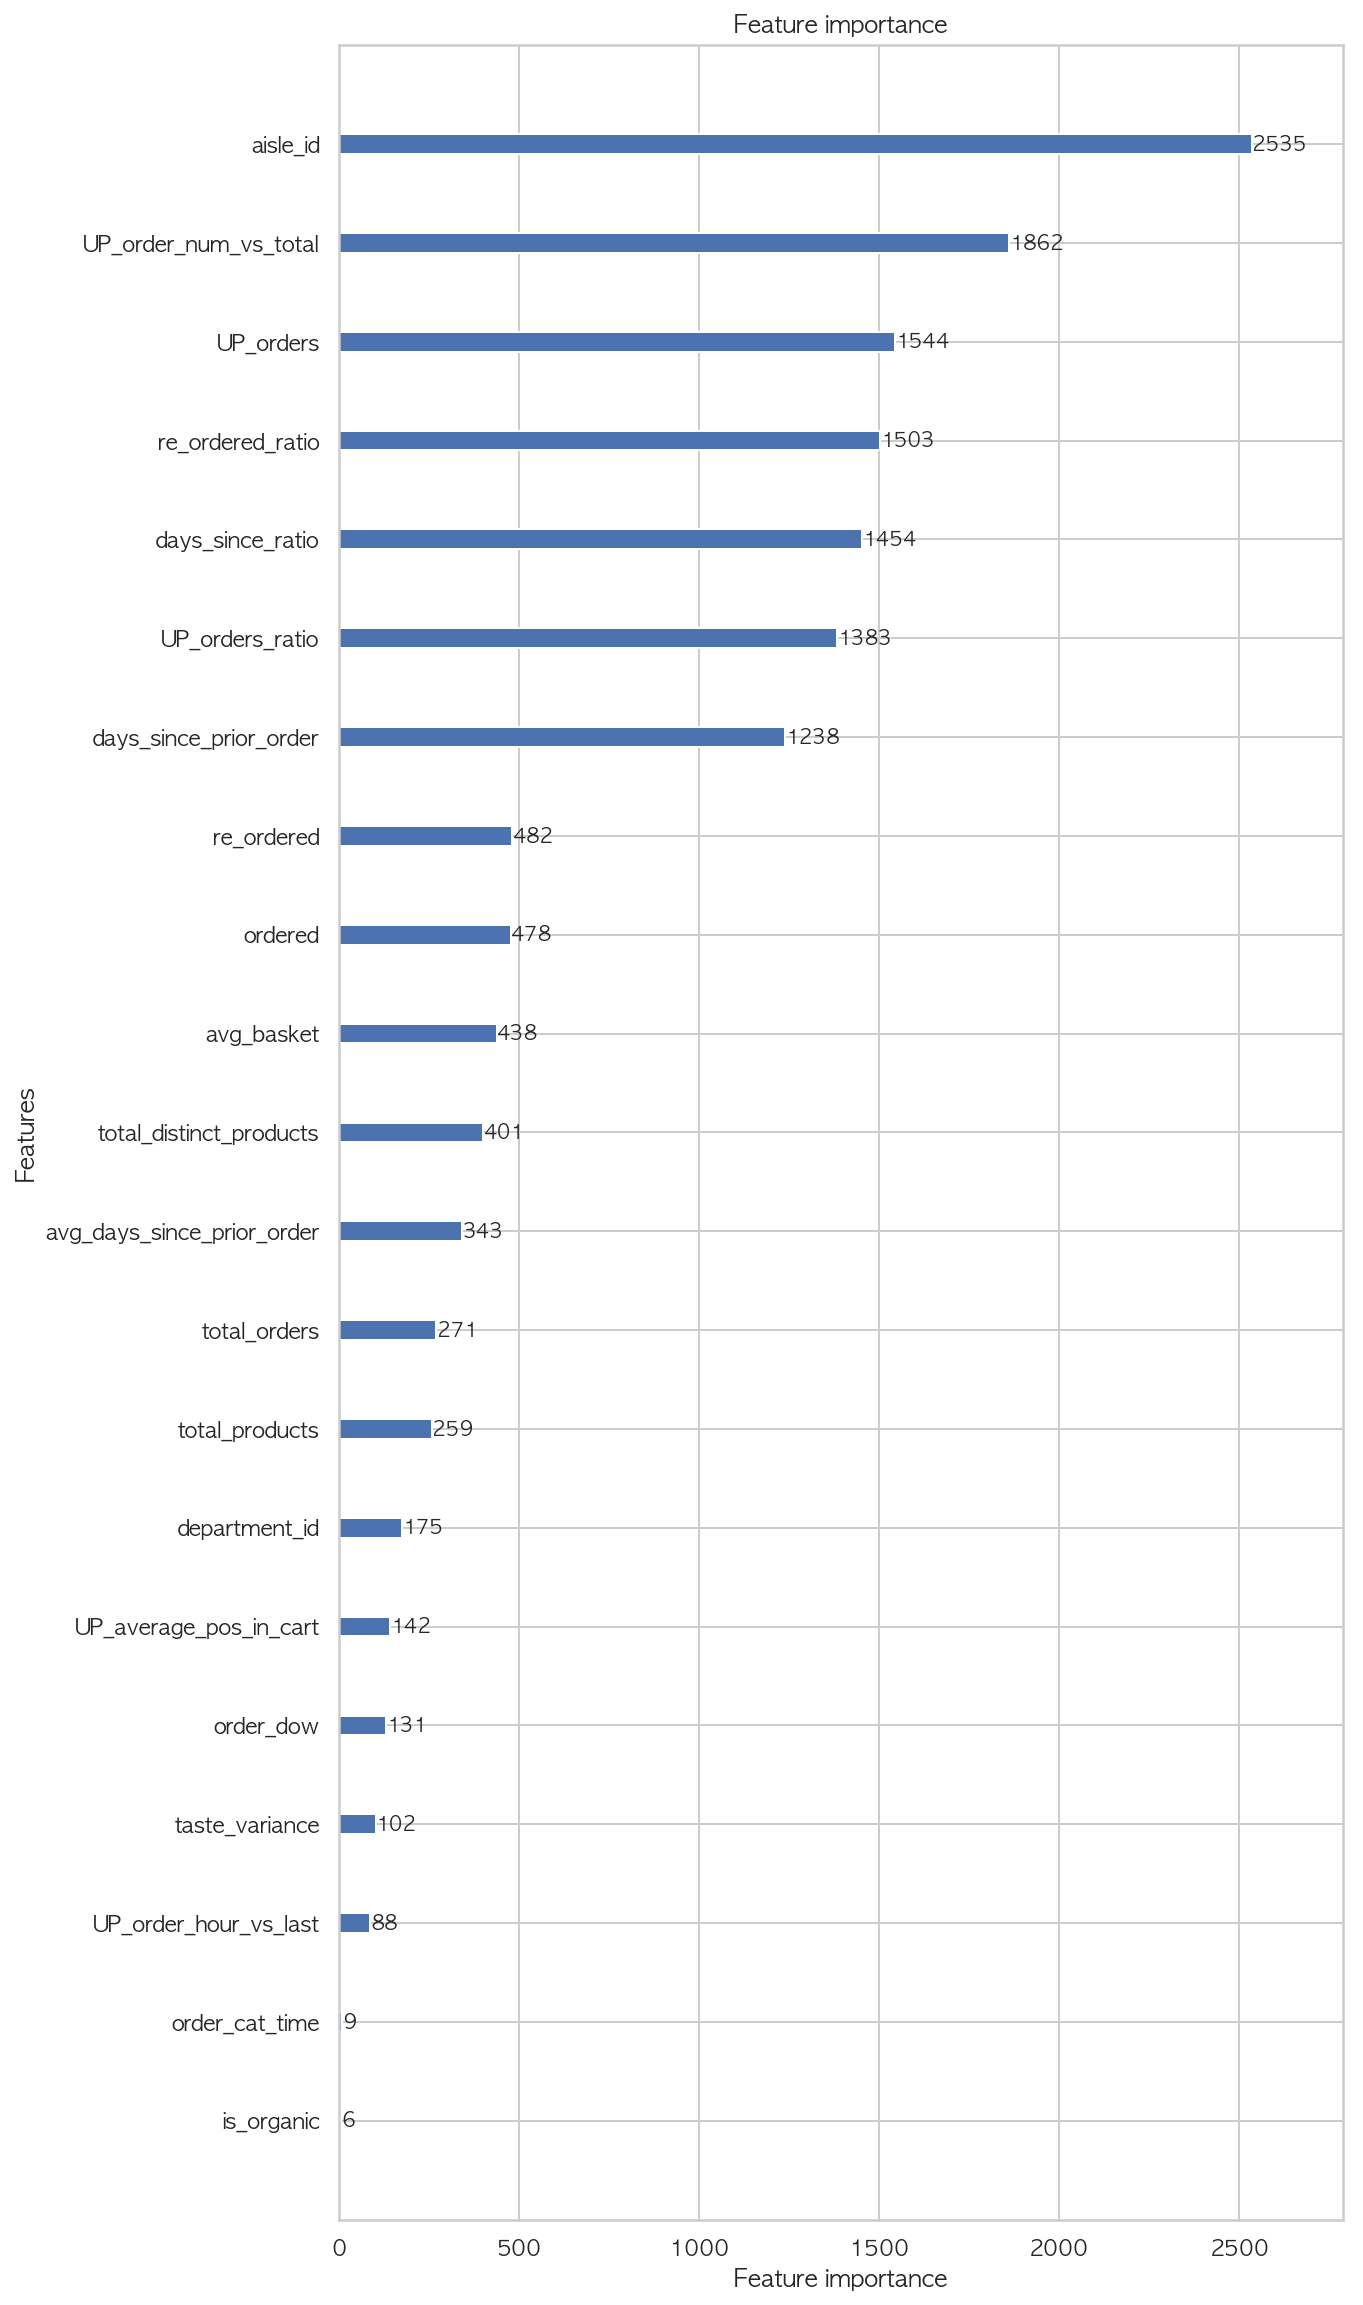

In [166]:
lgb.plot_importance(model, importance_type='split', figsize=(9, 20))

> - 상품의 카테고리를 나누는 `aisle_id`가 압도적으로 importance 수치가 높았습니다.
    - `aisle_id`에서 신선도가 중요한 상품(과일, 채소, 달걀, 우유 등)인지 아닌지의 여부가 가장 많은 정보량을 가지고 있다고 볼 수 있습니다.
- 그 다음으로는 `UP_order_num_vs_total`가 높은 중요도를 보였습니다.
    - 상품 구매의 주기성을 나타내는 feature 중 하나로 user의 총 주문 횟수에서 user가 가장 최근에 해당 상품을 구매한 주문 순번을 뺀 feature로, 0에 가까울수록 최근에 구매되었다는 것을 의미합니다.
- `is_organic`, `order_cat_time`은 초기의 예상보다 아주 낮은 수치를 나타냈습니다.
    - `is_organic`: 이전의 EDA 과정을 통해 재구매가 많이 이루어지는 상품군에서 유기농 상품의 비중이 크다는 것을 확인할 수 있었습니다. 그래서 유기농 상품인지의 여부가 굉장히 중요할 것이라고 판단했었는데, 실제로는 가장 낮은 feature importance 수치로 나타났습니다. 아마도 훈련에 cross-entropy를 사용하는 tree model의 특성 상 `is_organic`이 정보량이 가장 부족한 feature이기 때문에 importance 수치가 낮은 것으로 판단됩니다.
    - `order_cat_time`: 마찬가지로 주문이 이루어진 시간을 네 가지 시간대로 카테고리화하여 묶음으로써 모델의 성능 향상이 이루어질 것을 기대했는데 오히려 모델에서 사용되는 비중이 굉장히 낮았습니다. 오히려 continuous한 feature로 그대로 남겨두는 편이 정보량이 더 많아 모델에서 좀 더 효과적인 feature로 사용될 수 있을 것 같습니다.


---

## Review

1. 지금까지 다룬 프로젝트 데이터는 train.csv 하나의 파일 안에 데이터가 정리되어 있었으나 이번은 데이터 구조가 관계형 스키마로 짜여있고 데이터에 sequence가 존재하는 차이점이 있었습니다. 따라서 pandas를 활용한 feature engineering 작업이 이전의 프로젝트 경험보다 많이 동반되었는데 이 과정에서 스스로 많은 부족함을 느꼈습니다. 모델에 사용되는 feature의 갯수가 20개 남짓인데 너무 적은 것이 아닌가 하는 생각이 듭니다. 아무튼 현업에서도 feature engineering 작업이 전처리 작업과 더불어 가장 요구되는 스킬이 아닐까 하는 막연한 생각이 듭니다. 덧붙여 딥러닝은 feature engineering이 상대적으로 덜 요구되는 특성이 있기 때문에, 차라리 latent feature을 잡아주는 딥러닝 모델을 활용하는 것이 시간적으로 더 효율적일 수 있겠다는 생각도 들었습니다.

2. 프로젝트를 끝내면서 가장 반성한 점은 Kaggle에 제출한 답안의 score를 어떻게든 조금이라도 높여보려고 본래의 의도와 목적을 잊고 과도하게 Parameter tuning에 집착했다는 점입니다. 선택한 모델에 대한 깊이 있는 이해가 동반되지도 않은 상황에서 한참 헛다리를 짚고 있느라 많은 시간을 낭비했습니다. 처음에는 공부가 덜 된 상황에서 `max_depth`와 `num_leaves`가 모델의 성능을 가장 많이 좌우할 것이라고 믿고 있었는데, 좀 더 알아보고 공부를 해보니 `learning_rate`, `num_boost_round`가 학습에 상당히 중요한 영향을 미친다는 것을 뒤늦게 알았습니다. 비록 알게된 후에도 눈에 띄는 score 향상은 없었지만, 우선 깊이 있는 공부가 선행되어야 프로젝트 진행에서 있어서 불필요한 시간 낭비를 줄일 수 있다는 중요한 교훈을 깨달았습니다.

3. 프로젝트 초창기에는 데이터 파악 및 EDA 작업을 하면서 딥러닝의 RNN 모델 활용 방안을 고민했었습니다. 하지만 딥러닝 이전의 머신러닝 모델을 좀 더 확실하게 공부하고 싶었던 점, 딥러닝의 부족한 해석력으로 인해서 feature importance를 파악하기 어려울 수 있다는 점을 감안하여 딥러닝 활용은 다음 기회로 미루기로 결정했습니다. 앞으로는 주로 딥러닝 모델을 활용하는 프로젝트를 수행할 계획입니다.

4. 위에서 언급하였듯이 데이터의 sequential한 특성을 전혀 살리지 못한 것 같아 아쉽습니다. 마침 현재 NLP에 대해서 공부하고 있는 중인데, sequence data를 다루는 법에 대해서 더 공부를 해서 이번의 프로젝트를 좀 더 발전시키고 싶습니다. 또한 부스팅 모델과 딥러닝 모델을 동시에 활용하는 방안을 강구한다면 좀 더 효과적인 모델을 만들 수 있을 것이라 생각합니다.

5. 마지막으로 코드가 실행되는 시간이 무척이나 오래 걸린다는 문제점이 있습니다. (코드 전체가 다 돌아가는데 10분 이상 걸립니다) 시간이 가장 오래 소요되는 반복문에서 시간을 조금이라도 단축할 수 있는 코드를 고민하고 pandas 코드를 돌리는 부분은 mysqlclient를 통해 MySQL을 활용하는 등의 고민이 필요할 것 같습니다.

### Conform

1. 비정형 데이터를 다루는 것이 아닌 이상 딥러닝만이 답이 아닌 것은 확실합니다. 그런 면에서 boosting 모델에 대한 접근은 적절한 것 같습니다.
1. 다만 프로젝트의 목적이 구체적이고 확실하지 않아보입니다. 특히 결과적으로 볼 때 거의 유의미한 내용이 없습니다(모델로서의 가치가 떨어지는 결과와 그것으로 인하여 효과가 없는 근거, 어찌보면 너무 당연하여 인사이트를 주지 못하는 결과물 등). 포트폴리오로 쓰기 위해서는 boosting 모델을 공부한다던지 등의 좀 더 구체적인 목적을 정하고 그것에 대한 정밀한 접근을 통해 프로젝트의 가치와 자신의 능력을 어필할 필요가 있습니다.
1. Imbalanced data set에 대한 대책 마련이 필요해 보입니다. 가장 간단한 방법으로는 class weight를 부여하는 방법이 있습니다. 그리고 `train_test_split`이 label의 비율에 맞춰서 이루어지는 것이 맞는지 확인해볼 필요가 있습니다.
1. 학습 과정에서 첫번째 트리가 문제를 너무 많이 풀어버릴 경우 완성된 모델의 퍼포먼스가 낮아져버릴 수 있습니다. 이에 대한 대책으로 딥러닝의 drop-out처럼 첫번째 트리에서 과도한 학습이 이루어지는 것을 방지하는 방법이 있습니다. -> `dart`: https://arxiv.org/abs/1505.01866


---

##### The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <date>